In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

train_directory = "/Users/evangelosgeraridis/Desktop/MEAZON/September 2022"
test_directory = "/Users/evangelosgeraridis/Desktop/MEAZON/October 2022"


train_dataframes = {}
test_dataframes = {}


for file in os.listdir(train_directory):
    file_path = os.path.join(train_directory, file)
    if os.path.isfile(file_path) and file.endswith(".csv"):
        df = pd.read_csv(file_path)
        train_dataframes[file] = df

# Process test data
for file in os.listdir(test_directory):
    file_path = os.path.join(test_directory, file)
    if os.path.isfile(file_path) and file.endswith(".csv"):
        df = pd.read_csv(file_path)
        test_dataframes[file] = df

In [ ]:
entry_counts = []

# Count entries in train DataFrames
for name, df in train_dataframes.items():
    count_value = df.count()
    entry_counts.append(count_value.tolist())

# Show the minimum value of entry_counts
min_value = min(entry_counts)
print("Minimum value of entry_counts:", min_value)


Minimum value of entry_counts: [36615, 36615, 36615, 36615, 36615, 36615]


In [ ]:
entry_counts = []

# Count entries in train DataFrames
for name, df in test_dataframes.items():
    count_value = df.count()
    entry_counts.append(count_value.tolist())

# Show the minimum value of entry_counts
min_value = min(entry_counts)
print("Minimum value of entry_counts:", min_value)


Minimum value of entry_counts: [16042, 16042, 16042, 16042, 16042, 16042]


In [ ]:
limited_train_dataframes = {}

# Apply the limit to each train DataFrame
for key, df in train_dataframes.items():
    limited_train_dataframes[key] = df.iloc[:36615]


In [ ]:
limited_test_dataframes = {}

# Apply the limit to each train DataFrame
for key, df in test_dataframes.items():
    limited_test_dataframes[key] = df.iloc[:16042]


In [ ]:
washing_machine_train = limited_train_dataframes['washing_machineS.csv'].set_index('ts').dropna()
aggregated_train = limited_train_dataframes['AggregatedS.csv'].set_index('ts').dropna()
dishwasher_train = limited_train_dataframes['dishwasherS.csv'].set_index('ts').dropna()
water_heater_train = limited_train_dataframes['water_heaterS.csv'].set_index('ts').dropna()
fridge_train = limited_train_dataframes['fridgeS.csv'].set_index('ts').dropna()
microwave_train = limited_train_dataframes['microwaveS.csv'].set_index('ts').dropna()
hotplate_train = limited_train_dataframes['hotplateS.csv'].set_index('ts').dropna()

In [ ]:
washing_machine_test = limited_test_dataframes['washing_machineO.csv'].set_index('ts').dropna()
aggregated_test = limited_test_dataframes['AggregatedO.csv'].set_index('ts').dropna()
dishwasher_test = limited_test_dataframes['dishwasherO.csv'].set_index('ts').dropna()
water_heater_test = limited_test_dataframes['water_heaterO.csv'].set_index('ts').dropna()
fridge_test = limited_test_dataframes['fridgeO.csv'].set_index('ts').dropna()
microwave_test = limited_test_dataframes['microwaveO.csv'].set_index('ts').dropna()
hotplate_test = limited_test_dataframes['hotplateO.csv'].set_index('ts').dropna()

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score


class Hart85:
    def __init__(self, num_states = 5, num_cluster_init = 100, num_cycles_init = 5, num_cluster = 5):
        self.num_states = num_states
        self.num_cluster_init = num_cluster_init
        self.num_cycles_init = num_cycles_init
        self.num_cluster = num_cluster
        self.model = None

    def train(self, X):
        X = self.create_input(X)
        self.model = self.train_hart85(X)
        return self.model

    def create_input(self, X):
        n_samples, n_features = X.shape
        X_agg = np.zeros((n_samples, self.num_states))
        for i in range(n_samples):
            for j in range(self.num_states):
                X_agg[i, j] = np.sum(X[i, j * (n_features // self.num_states):(j + 1) * (n_features // self.num_states)])
        return X_agg

    def train_hart85(self, X):
        num_samples, num_features = X.shape
        X_states = np.zeros((num_samples, num_features))
        means = KMeans(n_clusters=self.num_cluster_init).fit(X).cluster_centers_
        knn = NearestNeighbors(n_neighbors=self.num_cluster_init).fit(X)
        for i in range(num_samples):
            _, indices = knn.kneighbors([X[i]])
            for j in range(self.num_cycles_init):
                for k in range(num_features):
                    if j < len(indices[0]):
                        if indices[0][j] < len(means):
                            X_states[i, k] = means[indices[0][j]][k]
        return X_states

    def disaggregate(self, X):
        n_samples, n_features = X.shape
        X_agg = self.create_input(X)
        n_cycles = self.num_cluster // self.num_cycles_init
        Y = np.zeros((n_samples, n_features * n_cycles))
        means = KMeans(n_clusters=self.num_cluster).fit(X_agg).cluster_centers_
        knn = NearestNeighbors(n_neighbors=self.num_cluster).fit(X_agg)
        for i in range(n_samples):
            _, indices = knn.kneighbors([X_agg[i]])
            for j in range(n_cycles):
                for k in range(self.num_cycles_init):
                    if indices[0][j * self.num_cycles_init + k] < len(means):
                        Y[i, j * self.num_cycles_init + k] = means[indices[0][j * self.num_cycles_init + k]][k]
        return Y

    def calculate_rmse(self, X_true, X_pred):
        return np.sqrt(mean_squared_error(X_true, X_pred))

    def calculate_mae(self, X_true, X_pred):
        return mean_absolute_error(X_true, X_pred)

    def calculate_rmae(self, X_true, X_pred):
        rmse = self.calculate_rmse(X_true, X_pred)
        return rmse / np.mean(X_true)

    def calculate_mse(self, X_true, X_pred):
        return mean_squared_error(X_true, X_pred)


## FRIDGE ##

X_train_fridge, X_test_fridge, Y_train_fridge, Y_test_fridge = aggregated_train.values, aggregated_test.values, fridge_train.values, fridge_test.values

hart85_disaggregator_fridge = Hart85(num_states=5, num_cluster=5)
hart85_disaggregator_fridge.train(X_train_fridge)

disaggregated_data_fridge = hart85_disaggregator_fridge.disaggregate(X_test_fridge)

columns = ["pwrA", "apwrA", "curA", "cltA", "screA"]

# Create an empty dictionary to store the metrics
metrics = {}

# Calculate and store the metrics for each column
for column in columns:
    column_true = Y_test_fridge[:, columns.index(column)]
    column_pred = disaggregated_data_fridge[:, columns.index(column)]

    rmse = hart85_disaggregator_fridge.calculate_rmse(column_true, column_pred)
    mae = hart85_disaggregator_fridge.calculate_mae(column_true, column_pred)
    rmae = hart85_disaggregator_fridge.calculate_rmae(column_true, column_pred)
    mse = hart85_disaggregator_fridge.calculate_mse(column_true, column_pred)
    r_squared = r2_score(column_true, column_pred)

    metrics[column] = {
        'RMSE': rmse,
        'MAE': mae,
        'RMAE': rmae,
        'MSE': mse,
        'R-squared': r_squared
    }

# Print the metrics for each column
for column, metrics_dict in metrics.items():
    print(f"Metrics for {column}:")
    for metric, value in metrics_dict.items():
        print(f"{metric}: {value}")
    print()





/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Metrics for pwrA:
RMSE: 337.24684048932187
MAE: 173.3643968198769
RMAE: 1.9469809675366958
MSE: 113735.4314200301
R-squared: -0.3620035838557327

Metrics for apwrA:
RMSE: 389.0503421955069
MAE: 214.59062163445813
RMAE: 1.8153556374755422
MSE: 151360.16876244103
R-squared: -0.4422956525653061

Metrics for curA:
RMSE: 1.759095922355886
MAE: 0.9683498422291489
RMAE: 1.8187901525516388
MSE: 3.0944184640491055
R-squared: -0.438783626520836

Metrics for cltA:
RMSE: 222.5336999694147
MAE: 222.4482376821414
RMAE: 0.999697024383096
MSE: 49521.247622077484
R-squared: -11309.818057185505

Metrics for screA:
RMSE: 0.7668593410345678
MAE: 0.7557225495901064
RMAE: 1.0148391701946544
MSE: 0.5880732489319715
R-squared: -33.71297576848507



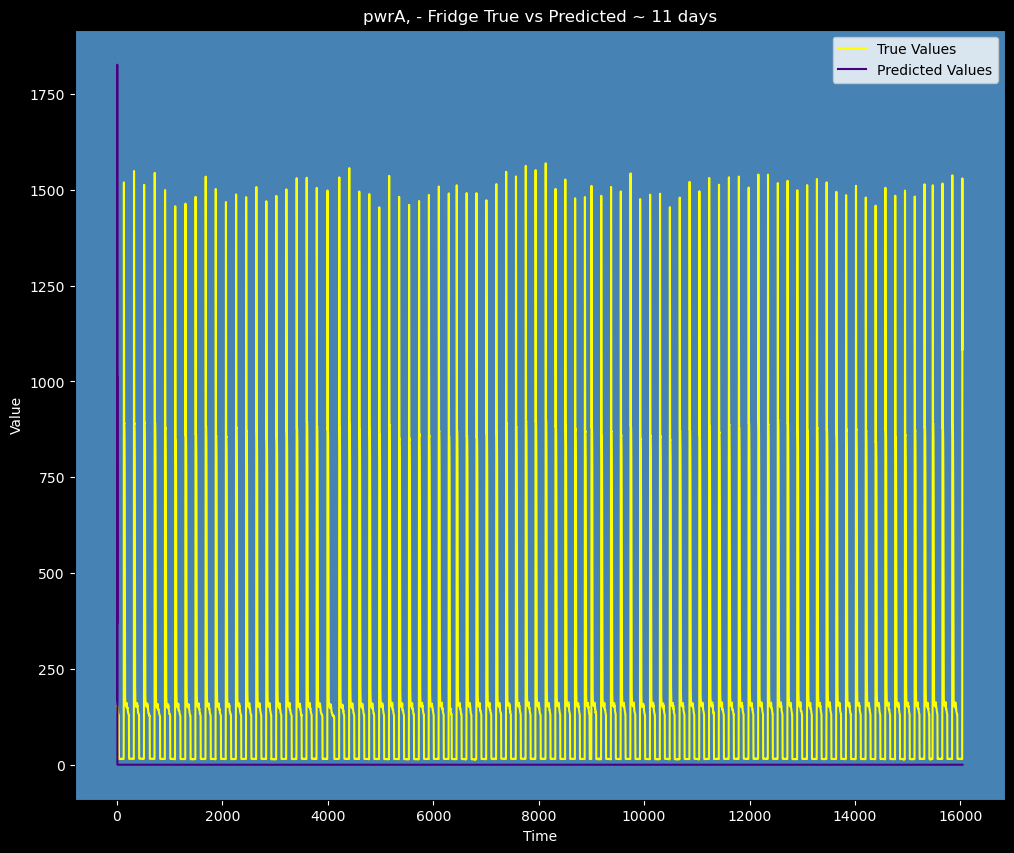

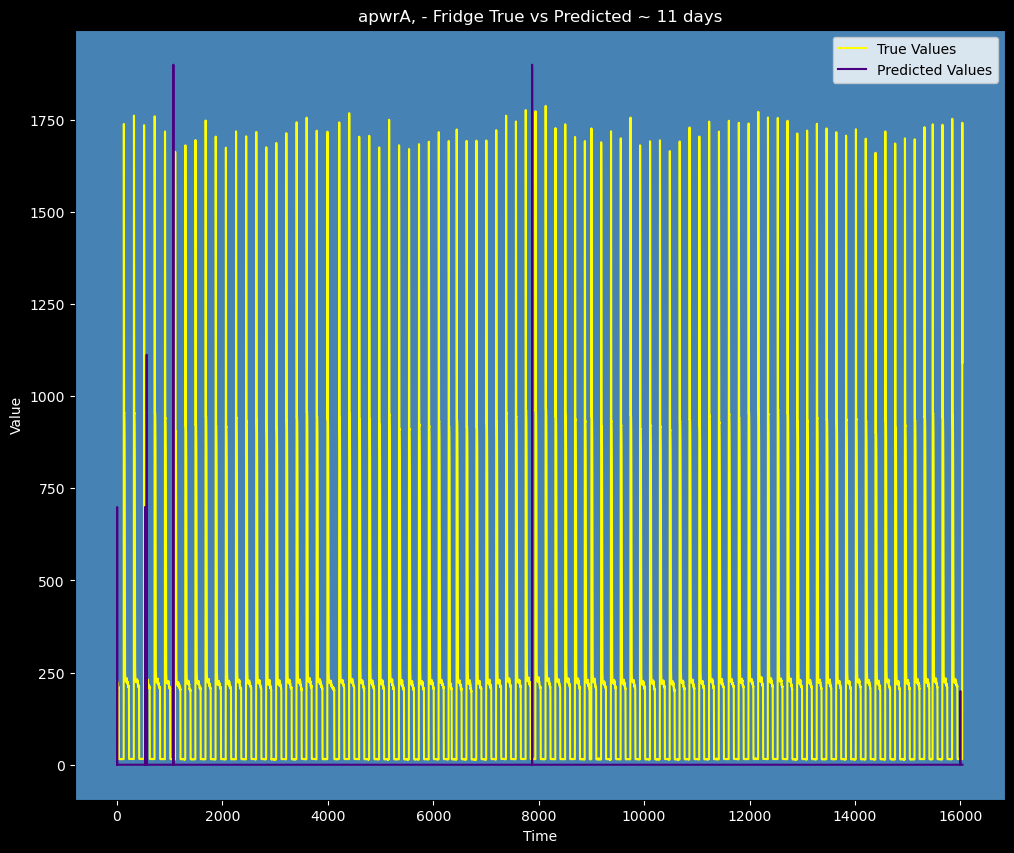

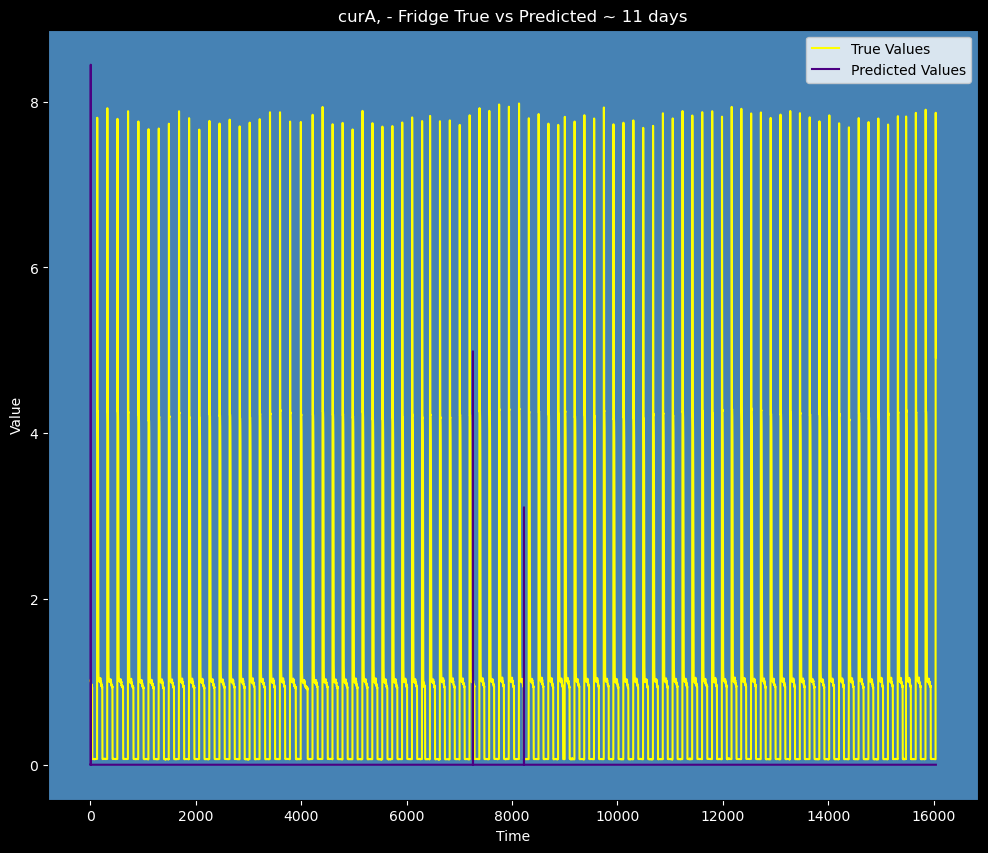

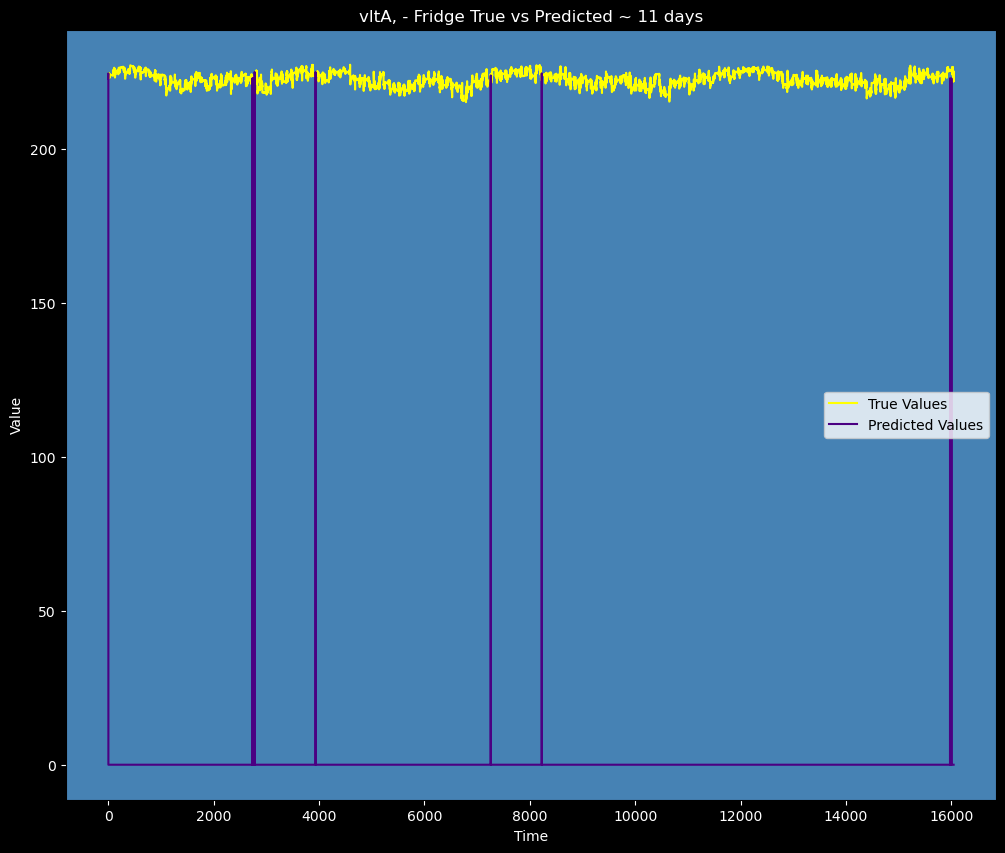

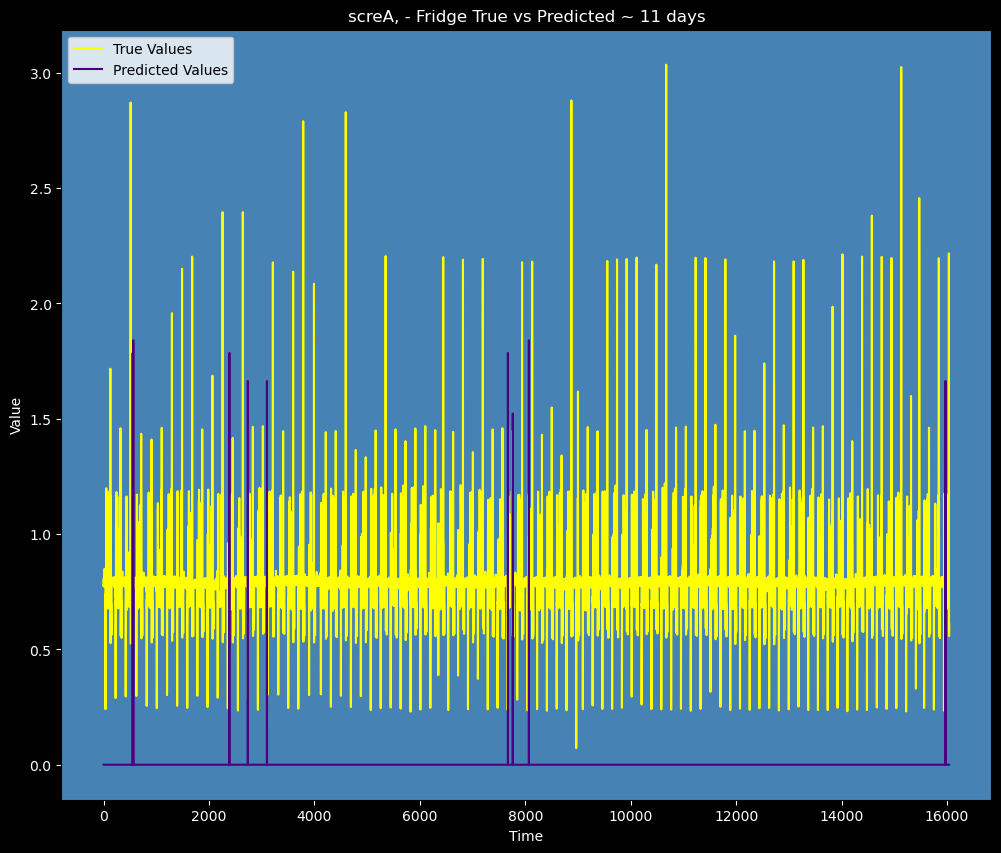

In [ ]:
import matplotlib.pyplot as plt
column_names = ['pwrA', 'apwrA','curA', 'vltA','screA']
j = 0
# Plotting the predicted values against the true values for each column
for i in range(Y_test_fridge.shape[1]):
    column_name = f"Column {i+1}"
    column_true = Y_test_fridge[:, i]
    column_pred = disaggregated_data_fridge[:, i]

    fig, ax = plt.subplots(figsize=(12, 10))
    fig.patch.set_facecolor('black')

    ax.plot(column_true, label="True Values", color='yellow')
    ax.plot(column_pred, label="Predicted Values", color = 'indigo')
    ax.set_xlabel("Time",color= 'white')
    ax.set_ylabel("Value", color = 'white')
    ax.set_title(column_names[j]+", - Fridge True vs Predicted ~ 11 days", color = 'white')
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    ax.legend()

    # Change the color of the plot background
    ax.set_facecolor('steelblue')

    plt.show()
    j +=1

In [ ]:
## the predictions here are not good at all so we are not going to try to isolate day intervals

## WASHING MACHINE ##

X_train_washing_machine, X_test_washing_machine, Y_train_washing_machine, Y_test_washing_machine = aggregated_train.values, aggregated_test.values, washing_machine_train.values, washing_machine_test.values

hart85_disaggregator_washing_machine = Hart85(num_states=5, num_cluster=5)
hart85_disaggregator_washing_machine.train(X_train_washing_machine)

disaggregated_data_washing_machine = hart85_disaggregator_washing_machine.disaggregate(X_test_washing_machine)

columns = ["pwrA", "apwrA", "curA", "cltA", "screA"]

# Create an empty dictionary to store the metrics
metrics = {}

# Calculate and store the metrics for each column
for column in columns:
    column_true = Y_test_washing_machine[:, columns.index(column)]
    column_pred = disaggregated_data_washing_machine[:, columns.index(column)]

    rmse = hart85_disaggregator_washing_machine.calculate_rmse(column_true, column_pred)
    mae = hart85_disaggregator_washing_machine.calculate_mae(column_true, column_pred)
    rmae = hart85_disaggregator_washing_machine.calculate_rmae(column_true, column_pred)
    mse = hart85_disaggregator_washing_machine.calculate_mse(column_true, column_pred)
    r_squared = r2_score(column_true, column_pred)

    metrics[column] = {
        'RMSE': rmse,
        'MAE': mae,
        'RMAE': rmae,
        'MSE': mse,
        'R-squared': r_squared
    }

# Print the metrics for each column
for column, metrics_dict in metrics.items():
    print(f"Metrics for {column}:")
    for metric, value in metrics_dict.items():
        print(f"{metric}: {value}")
    print()


/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Metrics for pwrA:
RMSE: 822.2187184824875
MAE: 367.91994544224315
RMAE: 2.2362664003884904
MSE: 676043.621022984
R-squared: -0.2506418082908537

Metrics for apwrA:
RMSE: 824.4663957956158
MAE: 372.642439798281
RMAE: 2.2140835893086033
MSE: 679744.837796213
R-squared: -0.25673579588750073

Metrics for curA:
RMSE: 3.7730644214834057
MAE: 1.702376399680944
RMAE: 2.217573154064714
MSE: 14.236015128663906
R-squared: -0.25574136063548414

Metrics for cltA:
RMSE: 222.0273710276434
MAE: 221.94137342392696
RMAE: 0.9997006733092985
MSE: 49296.15348544683
R-squared: -10278.756821139485

Metrics for screA:
RMSE: 1.0980534787067147
MAE: 1.0424686091155602
RMAE: 1.053025889495133
MSE: 1.2057214420999174
R-squared: -9.14463519046307



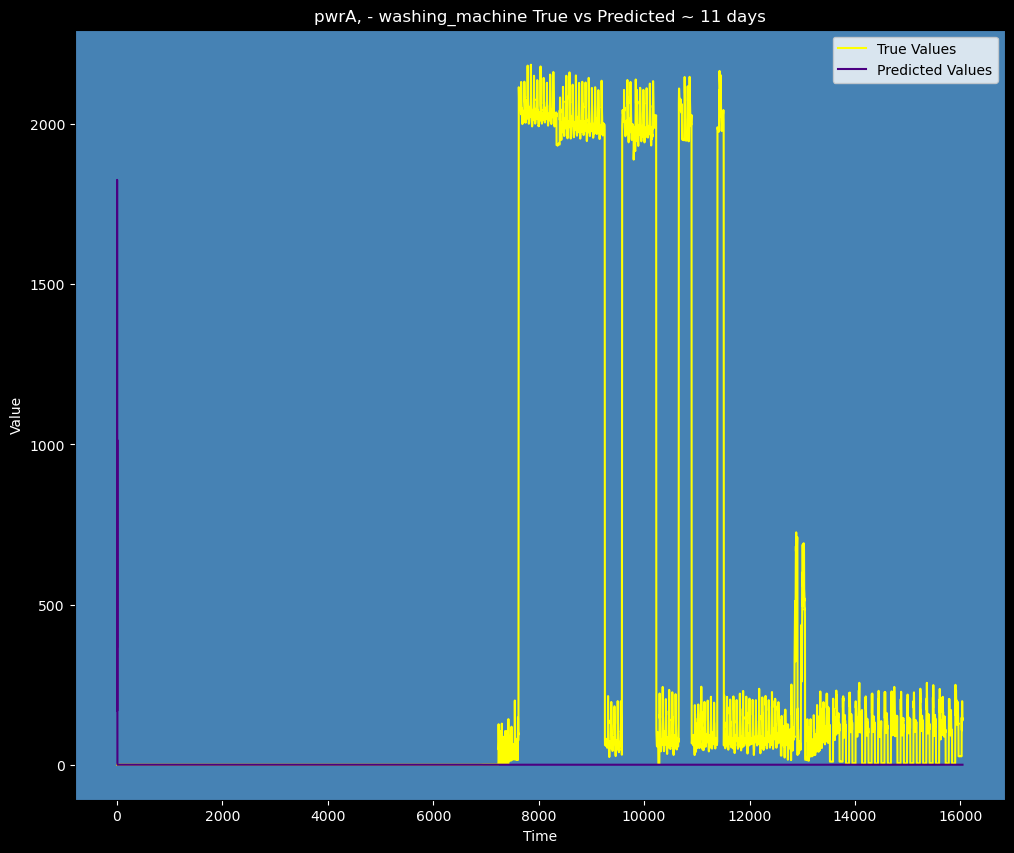

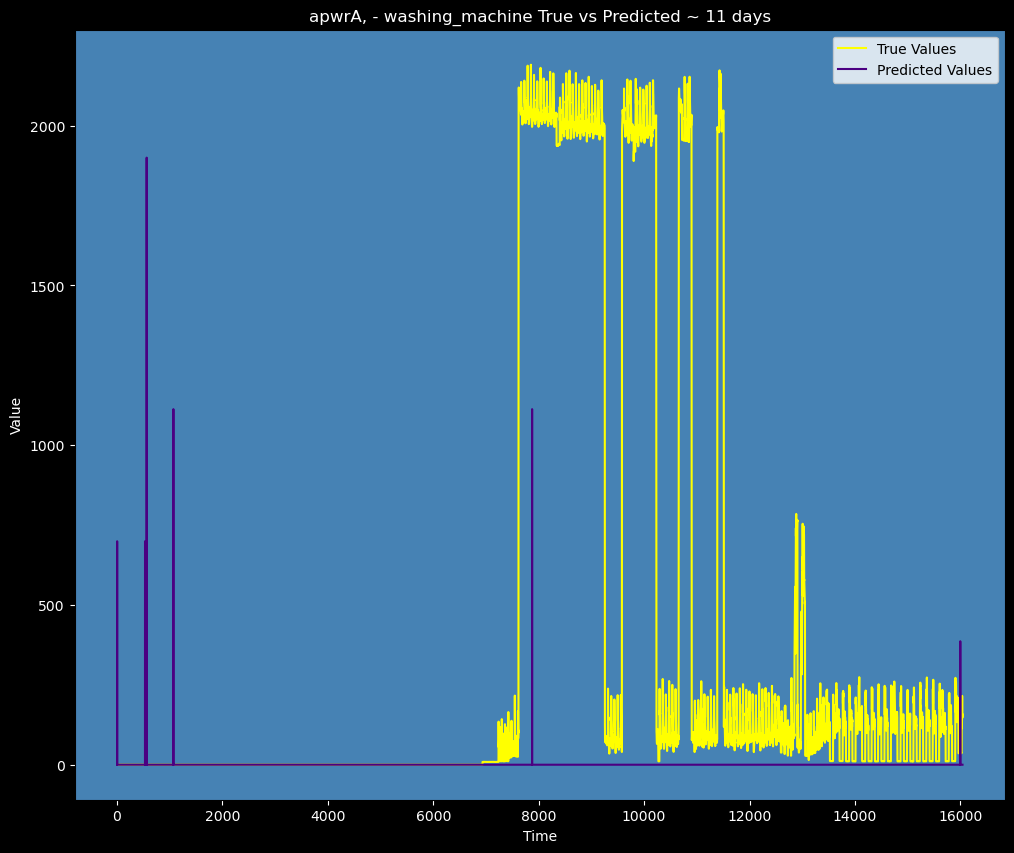

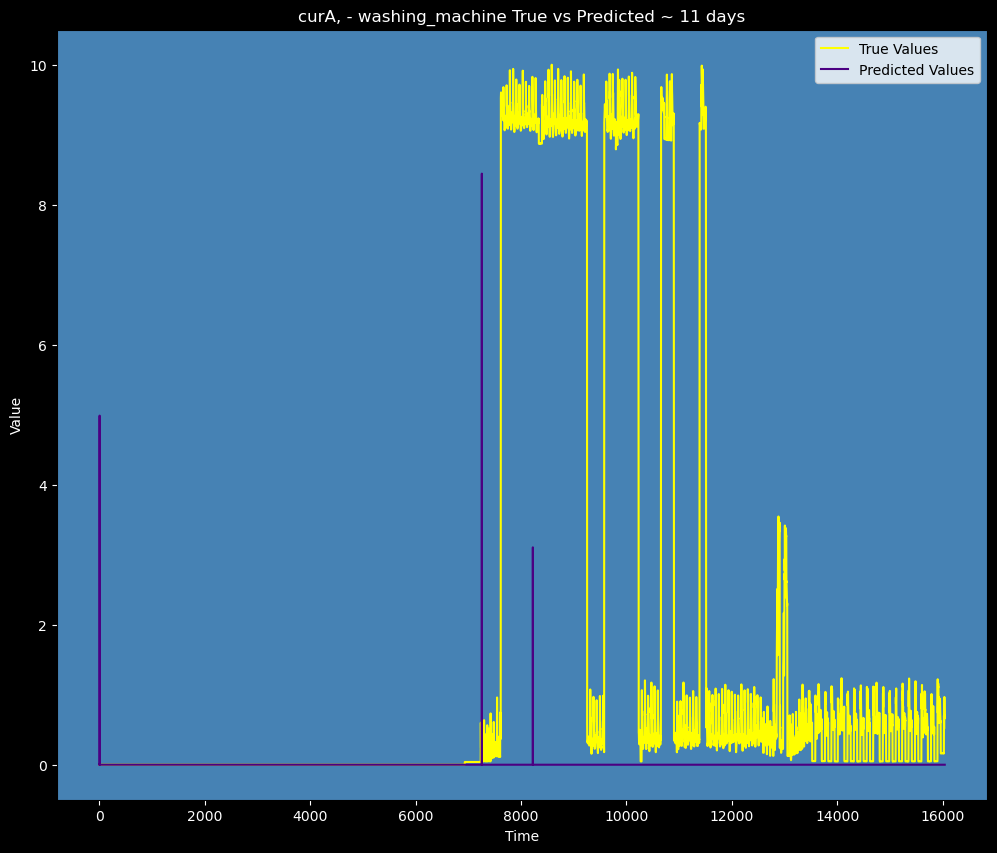

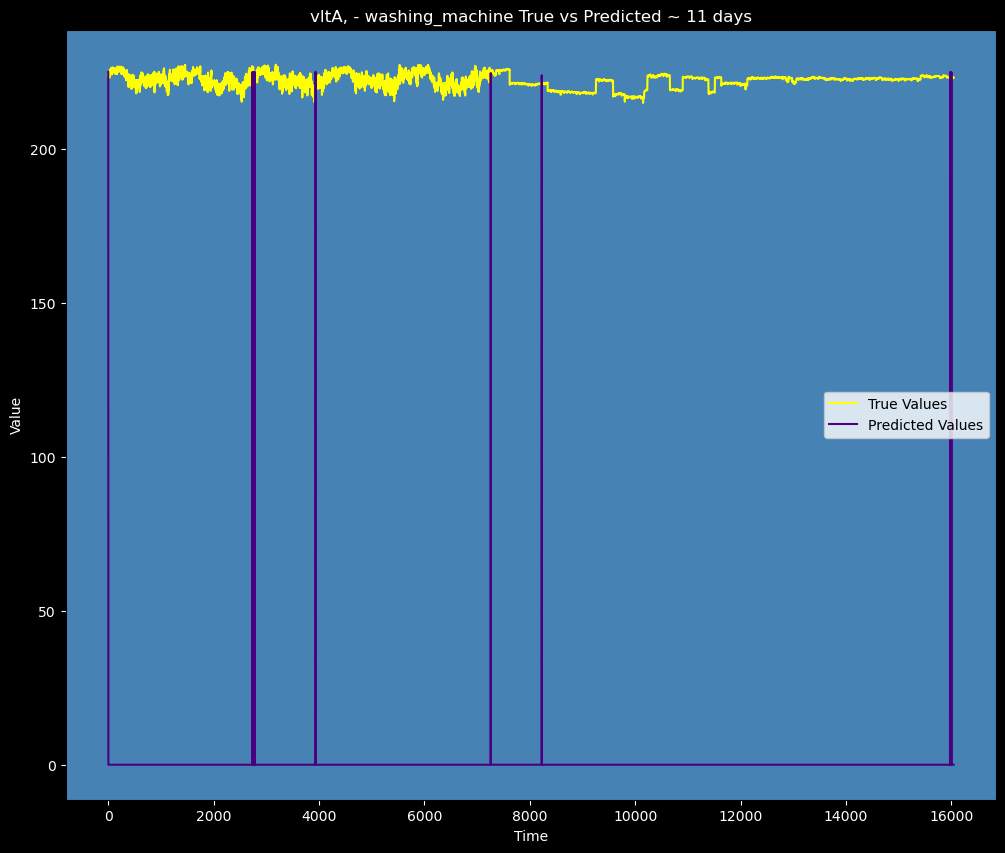

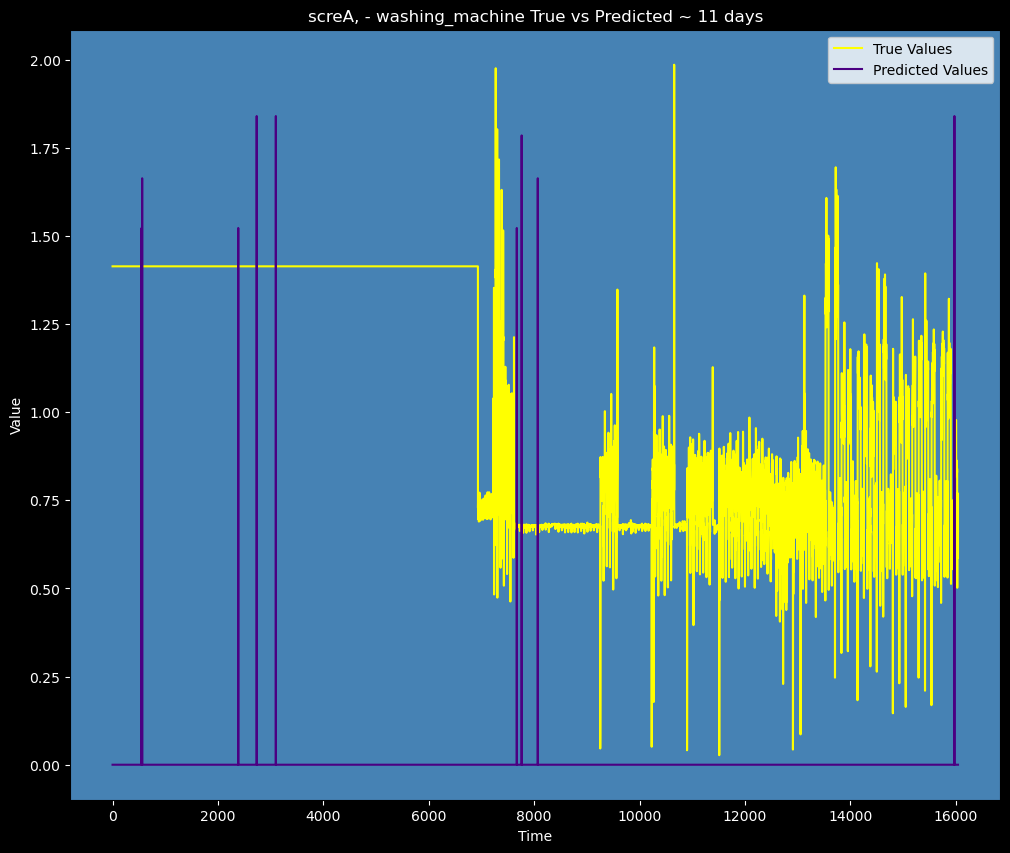

In [ ]:
import matplotlib.pyplot as plt
column_names = ['pwrA', 'apwrA','curA', 'vltA','screA']
j = 0
# Plotting the predicted values against the true values for each column
for i in range(Y_test_washing_machine.shape[1]):
    column_name = f"Column {i+1}"
    column_true = Y_test_washing_machine[:, i]
    column_pred = disaggregated_data_washing_machine[:, i]

    fig, ax = plt.subplots(figsize=(12, 10))
    fig.patch.set_facecolor('black')

    ax.plot(column_true, label="True Values", color='yellow')
    ax.plot(column_pred, label="Predicted Values", color = 'indigo')
    ax.set_xlabel("Time",color= 'white')
    ax.set_ylabel("Value", color = 'white')
    ax.set_title(column_names[j]+", - washing_machine True vs Predicted ~ 11 days", color = 'white')
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    ax.legend()

    # Change the color of the plot background
    ax.set_facecolor('steelblue')

    plt.show()
    j +=1

In [ ]:
##  DISHWASHER ##

import numpy as np
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score


class Hart85:
    def __init__(self, num_states = 5, num_cluster_init = 100, num_cycles_init = 5, num_cluster = 5):
        self.num_states = num_states
        self.num_cluster_init = num_cluster_init
        self.num_cycles_init = num_cycles_init
        self.num_cluster = num_cluster
        self.model = None

    def train(self, X):
        X = self.create_input(X)
        self.model = self.train_hart85(X)
        return self.model

    def create_input(self, X):
        n_samples, n_features = X.shape
        X_agg = np.zeros((n_samples, self.num_states))
        for i in range(n_samples):
            for j in range(self.num_states):
                X_agg[i, j] = np.sum(X[i, j * (n_features // self.num_states):(j + 1) * (n_features // self.num_states)])
        return X_agg

    def train_hart85(self, X):
        num_samples, num_features = X.shape
        X_states = np.zeros((num_samples, num_features))
        means = KMeans(n_clusters=self.num_cluster_init).fit(X).cluster_centers_
        knn = NearestNeighbors(n_neighbors=self.num_cluster_init).fit(X)
        for i in range(num_samples):
            _, indices = knn.kneighbors([X[i]])
            for j in range(self.num_cycles_init):
                for k in range(num_features):
                    if j < len(indices[0]):
                        if indices[0][j] < len(means):
                            X_states[i, k] = means[indices[0][j]][k]
        return X_states

    def disaggregate(self, X):
        n_samples, n_features = X.shape
        X_agg = self.create_input(X)
        n_cycles = self.num_cluster // self.num_cycles_init
        Y = np.zeros((n_samples, n_features * n_cycles))
        means = KMeans(n_clusters=self.num_cluster).fit(X_agg).cluster_centers_
        knn = NearestNeighbors(n_neighbors=self.num_cluster).fit(X_agg)
        for i in range(n_samples):
            _, indices = knn.kneighbors([X_agg[i]])
            for j in range(n_cycles):
                for k in range(self.num_cycles_init):
                    if indices[0][j * self.num_cycles_init + k] < len(means):
                        Y[i, j * self.num_cycles_init + k] = means[indices[0][j * self.num_cycles_init + k]][k]
        return Y

    def calculate_rmse(self, X_true, X_pred):
        return np.sqrt(mean_squared_error(X_true, X_pred))

    def calculate_mae(self, X_true, X_pred):
        return mean_absolute_error(X_true, X_pred)

    def calculate_rmae(self, X_true, X_pred):
        rmse = self.calculate_rmse(X_true, X_pred)
        return rmse / np.mean(X_true)

    def calculate_mse(self, X_true, X_pred):
        return mean_squared_error(X_true, X_pred)


## dishwasher ##

X_train_dishwasher, X_test_dishwasher, Y_train_dishwasher, Y_test_dishwasher = aggregated_train.values, aggregated_test.values, dishwasher_train.values, dishwasher_test.values

hart85_disaggregator_dishwasher = Hart85(num_states=5, num_cluster=5)
hart85_disaggregator_dishwasher.train(X_train_dishwasher)

disaggregated_data_dishwasher = hart85_disaggregator_dishwasher.disaggregate(X_test_dishwasher)

columns = ["pwrA", "apwrA", "curA", "cltA", "screA"]

# Create an empty dictionary to store the metrics
metrics = {}

# Calculate and store the metrics for each column
for column in columns:
    column_true = Y_test_dishwasher[:, columns.index(column)]
    column_pred = disaggregated_data_dishwasher[:, columns.index(column)]

    rmse = hart85_disaggregator_dishwasher.calculate_rmse(column_true, column_pred)
    mae = hart85_disaggregator_dishwasher.calculate_mae(column_true, column_pred)
    rmae = hart85_disaggregator_dishwasher.calculate_rmae(column_true, column_pred)
    mse = hart85_disaggregator_dishwasher.calculate_mse(column_true, column_pred)
    r_squared = r2_score(column_true, column_pred)

    metrics[column] = {
        'RMSE': rmse,
        'MAE': mae,
        'RMAE': rmae,
        'MSE': mse,
        'R-squared': r_squared
    }

# Print the metrics for each column
for column, metrics_dict in metrics.items():
    print(f"Metrics for {column}:")
    for metric, value in metrics_dict.items():
        print(f"{metric}: {value}")
    print()





/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Metrics for pwrA:
RMSE: 323.1703463005877
MAE: 55.85008233290522
RMAE: 5.819139800193329
MSE: 104439.07272804179
R-squared: -0.03350483306798768

Metrics for apwrA:
RMSE: 326.2798990069359
MAE: 64.18494818969859
RMAE: 5.099211388971982
MSE: 106458.57249597629
R-squared: -0.04136831248728523

Metrics for curA:
RMSE: 1.5017816798122086
MAE: 0.29456061784077847
RMAE: 5.119965237431023
MSE: 2.255348213819579
R-squared: -0.043346894135841696

Metrics for cltA:
RMSE: 222.35787103481118
MAE: 222.27177498748458
RMAE: 0.9997042188166216
MSE: 49443.02281113373
R-squared: -10172.341430201293

Metrics for screA:
RMSE: 1.0482109159438955
MAE: 0.9248120215073221
RMAE: 1.1335222815978578
MSE: 1.0987461243039403
R-squared: -3.5127860166945366



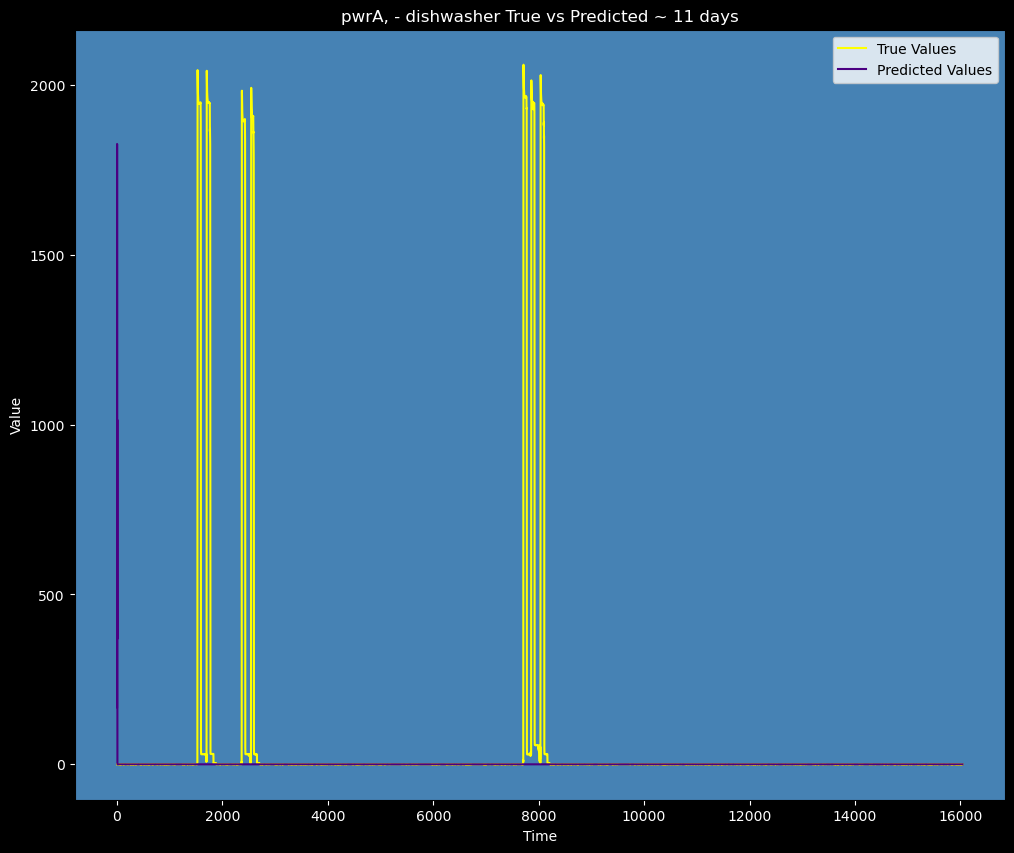

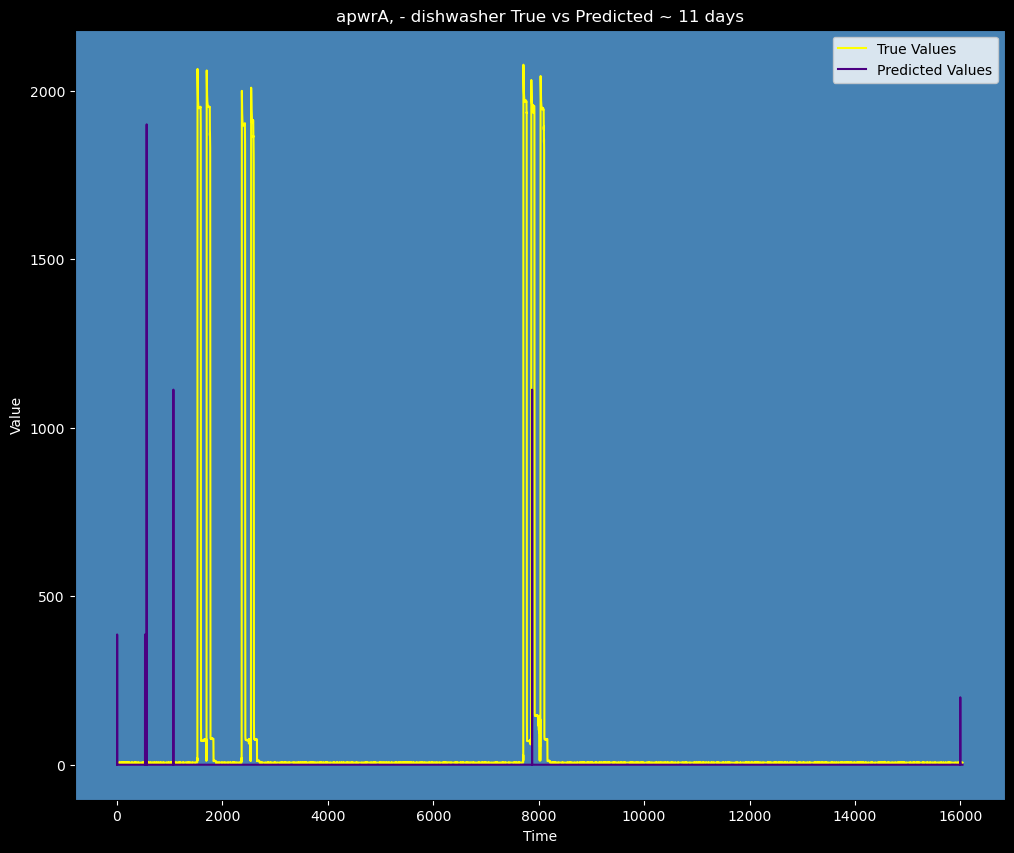

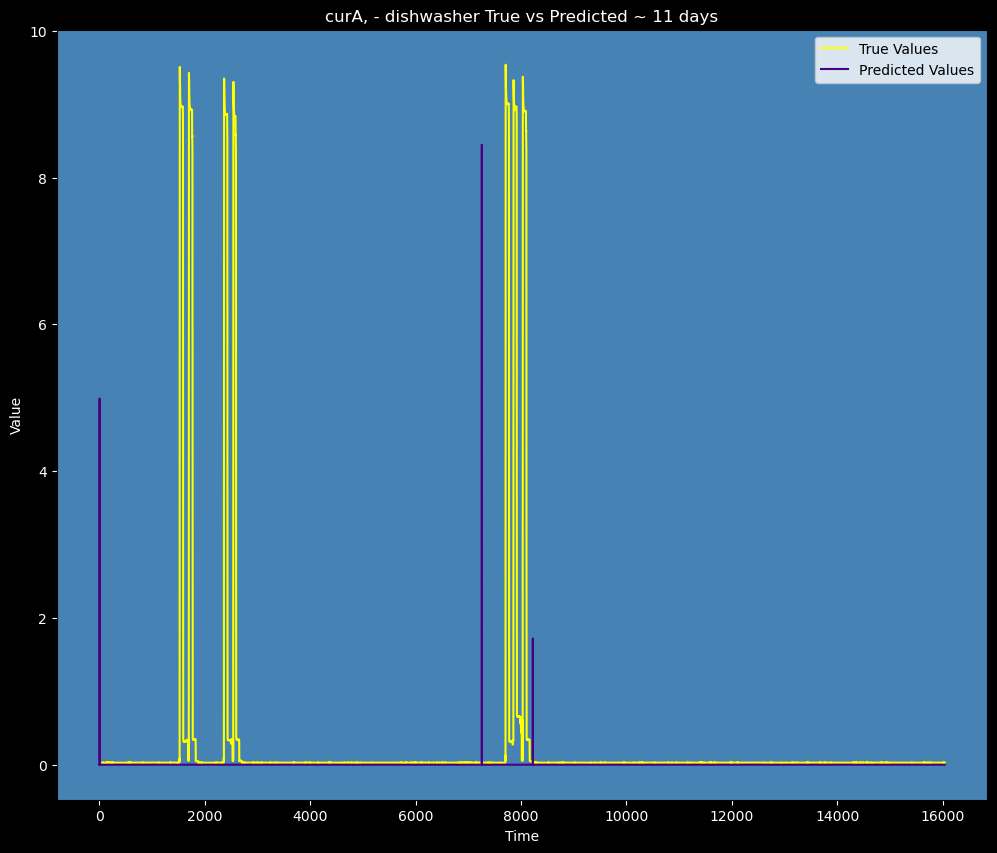

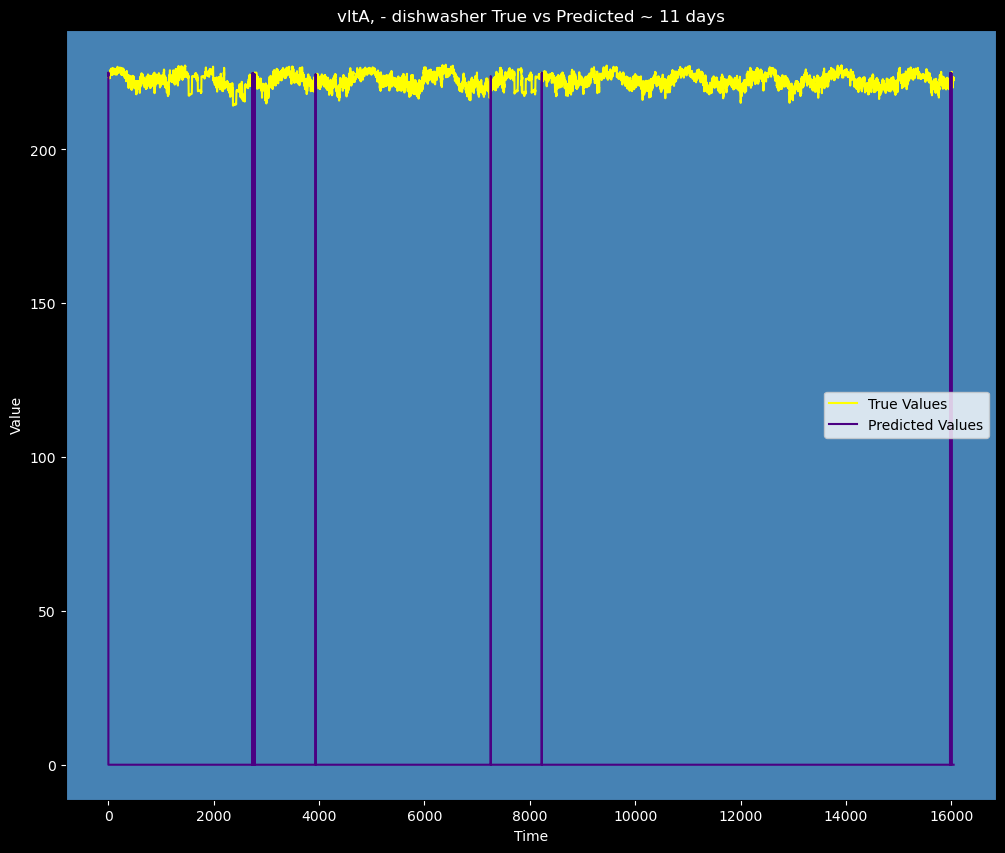

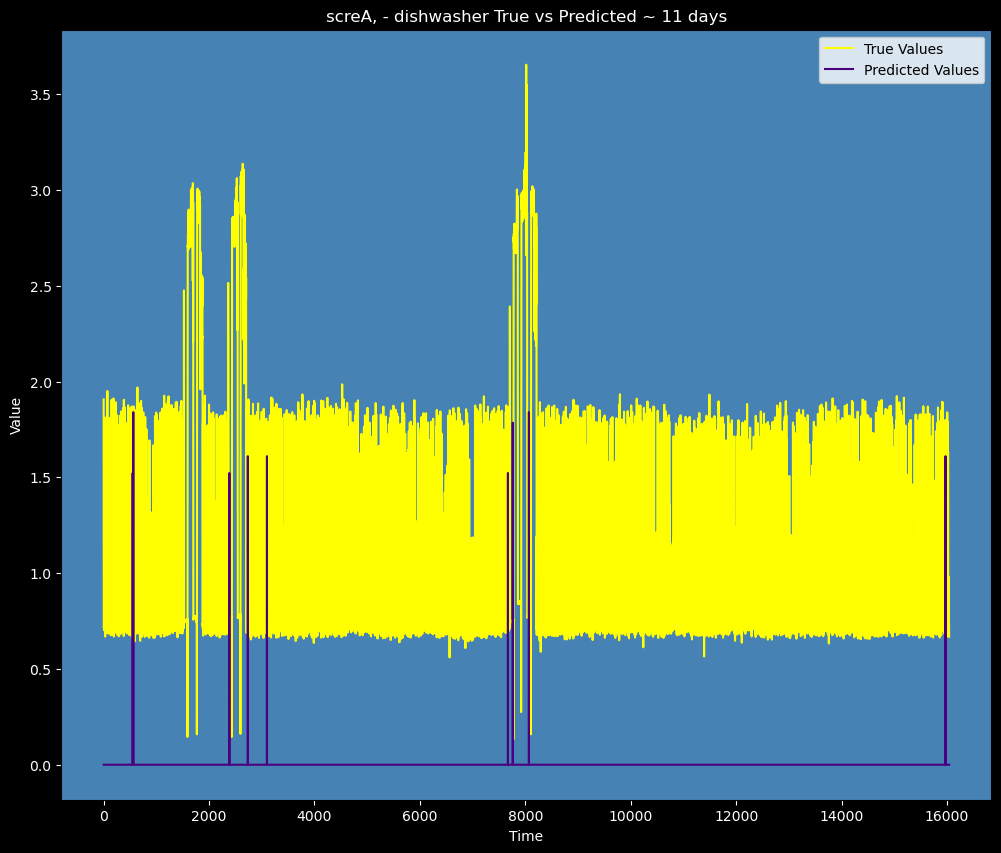

In [ ]:
import matplotlib.pyplot as plt
column_names = ['pwrA', 'apwrA','curA', 'vltA','screA']
j = 0
# Plotting the predicted values against the true values for each column
for i in range(Y_test_dishwasher.shape[1]):
    column_name = f"Column {i+1}"
    column_true = Y_test_dishwasher[:, i]
    column_pred = disaggregated_data_dishwasher[:, i]

    fig, ax = plt.subplots(figsize=(12, 10))
    fig.patch.set_facecolor('black')

    ax.plot(column_true, label="True Values", color='yellow')
    ax.plot(column_pred, label="Predicted Values", color = 'indigo')
    ax.set_xlabel("Time",color= 'white')
    ax.set_ylabel("Value", color = 'white')
    ax.set_title(column_names[j]+", - dishwasher True vs Predicted ~ 11 days", color = 'white')
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    ax.legend()

    # Change the color of the plot background
    ax.set_facecolor('steelblue')

    plt.show()
    j +=1

In [ ]:
## Microwave ##

import numpy as np
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score


class Hart85:
    def __init__(self, num_states = 5, num_cluster_init = 100, num_cycles_init = 5, num_cluster = 5):
        self.num_states = num_states
        self.num_cluster_init = num_cluster_init
        self.num_cycles_init = num_cycles_init
        self.num_cluster = num_cluster
        self.model = None

    def train(self, X):
        X = self.create_input(X)
        self.model = self.train_hart85(X)
        return self.model

    def create_input(self, X):
        n_samples, n_features = X.shape
        X_agg = np.zeros((n_samples, self.num_states))
        for i in range(n_samples):
            for j in range(self.num_states):
                X_agg[i, j] = np.sum(X[i, j * (n_features // self.num_states):(j + 1) * (n_features // self.num_states)])
        return X_agg

    def train_hart85(self, X):
        num_samples, num_features = X.shape
        X_states = np.zeros((num_samples, num_features))
        means = KMeans(n_clusters=self.num_cluster_init).fit(X).cluster_centers_
        knn = NearestNeighbors(n_neighbors=self.num_cluster_init).fit(X)
        for i in range(num_samples):
            _, indices = knn.kneighbors([X[i]])
            for j in range(self.num_cycles_init):
                for k in range(num_features):
                    if j < len(indices[0]):
                        if indices[0][j] < len(means):
                            X_states[i, k] = means[indices[0][j]][k]
        return X_states

    def disaggregate(self, X):
        n_samples, n_features = X.shape
        X_agg = self.create_input(X)
        n_cycles = self.num_cluster // self.num_cycles_init
        Y = np.zeros((n_samples, n_features * n_cycles))
        means = KMeans(n_clusters=self.num_cluster).fit(X_agg).cluster_centers_
        knn = NearestNeighbors(n_neighbors=self.num_cluster).fit(X_agg)
        for i in range(n_samples):
            _, indices = knn.kneighbors([X_agg[i]])
            for j in range(n_cycles):
                for k in range(self.num_cycles_init):
                    if indices[0][j * self.num_cycles_init + k] < len(means):
                        Y[i, j * self.num_cycles_init + k] = means[indices[0][j * self.num_cycles_init + k]][k]
        return Y

    def calculate_rmse(self, X_true, X_pred):
        return np.sqrt(mean_squared_error(X_true, X_pred))

    def calculate_mae(self, X_true, X_pred):
        return mean_absolute_error(X_true, X_pred)

    def calculate_rmae(self, X_true, X_pred):
        rmse = self.calculate_rmse(X_true, X_pred)
        return rmse / np.mean(X_true)

    def calculate_mse(self, X_true, X_pred):
        return mean_squared_error(X_true, X_pred)


## microwave ##

X_train_microwave, X_test_microwave, Y_train_microwave, Y_test_microwave = aggregated_train.values, aggregated_test.values, microwave_train.values, microwave_test.values

hart85_disaggregator_microwave = Hart85(num_states=5, num_cluster=5)
hart85_disaggregator_microwave.train(X_train_microwave)

disaggregated_data_microwave = hart85_disaggregator_microwave.disaggregate(X_test_microwave)

columns = ["pwrA", "apwrA", "curA", "cltA", "screA"]

# Create an empty dictionary to store the metrics
metrics = {}

# Calculate and store the metrics for each column
for column in columns:
    column_true = Y_test_microwave[:, columns.index(column)]
    column_pred = disaggregated_data_microwave[:, columns.index(column)]

    rmse = hart85_disaggregator_microwave.calculate_rmse(column_true, column_pred)
    mae = hart85_disaggregator_microwave.calculate_mae(column_true, column_pred)
    rmae = hart85_disaggregator_microwave.calculate_rmae(column_true, column_pred)
    mse = hart85_disaggregator_microwave.calculate_mse(column_true, column_pred)
    r_squared = r2_score(column_true, column_pred)

    metrics[column] = {
        'RMSE': rmse,
        'MAE': mae,
        'RMAE': rmae,
        'MSE': mse,
        'R-squared': r_squared
    }

# Print the metrics for each column
for column, metrics_dict in metrics.items():
    print(f"Metrics for {column}:")
    for metric, value in metrics_dict.items():
        print(f"{metric}: {value}")
    print()





/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Metrics for pwrA:
RMSE: 369.80978364233096
MAE: 132.2781871203382
RMAE: 2.800889755226967
MSE: 136759.27607758765
R-squared: -0.1489955979869495

Metrics for apwrA:
RMSE: 458.21955151872436
MAE: 209.42598838873494
RMAE: 2.193567942611719
MSE: 209965.1573940209
R-squared: -0.268598893236619

Metrics for curA:
RMSE: 2.062264955263909
MAE: 0.9406406149903159
RMAE: 2.1952491298123435
MSE: 4.252936745709654
R-squared: -0.264531450219184

Metrics for cltA:
RMSE: 223.06420336253532
MAE: 222.97632727184288
RMAE: 0.9997092169189532
MSE: 49757.63882176251
R-squared: -8819.847616783522

Metrics for screA:
RMSE: 0.8426413841576922
MAE: 0.8257229480687812
RMAE: 1.0206770623149757
MSE: 0.7100445022951914
R-squared: -24.176299582749674



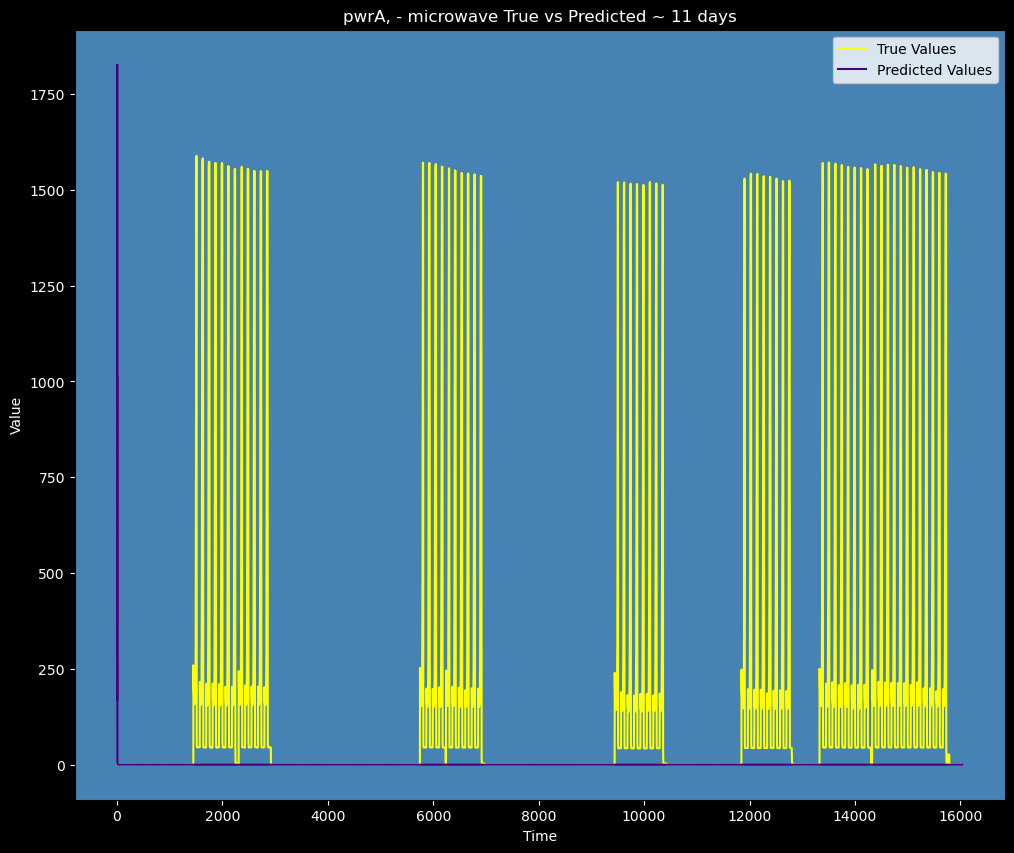

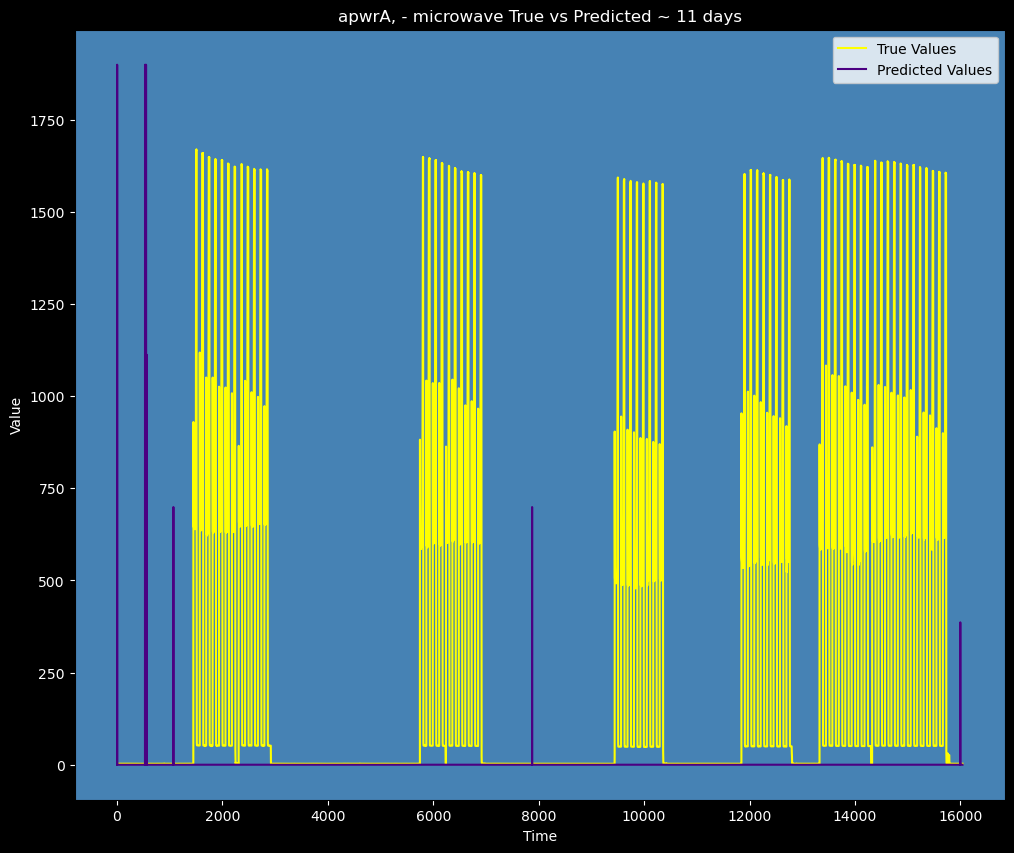

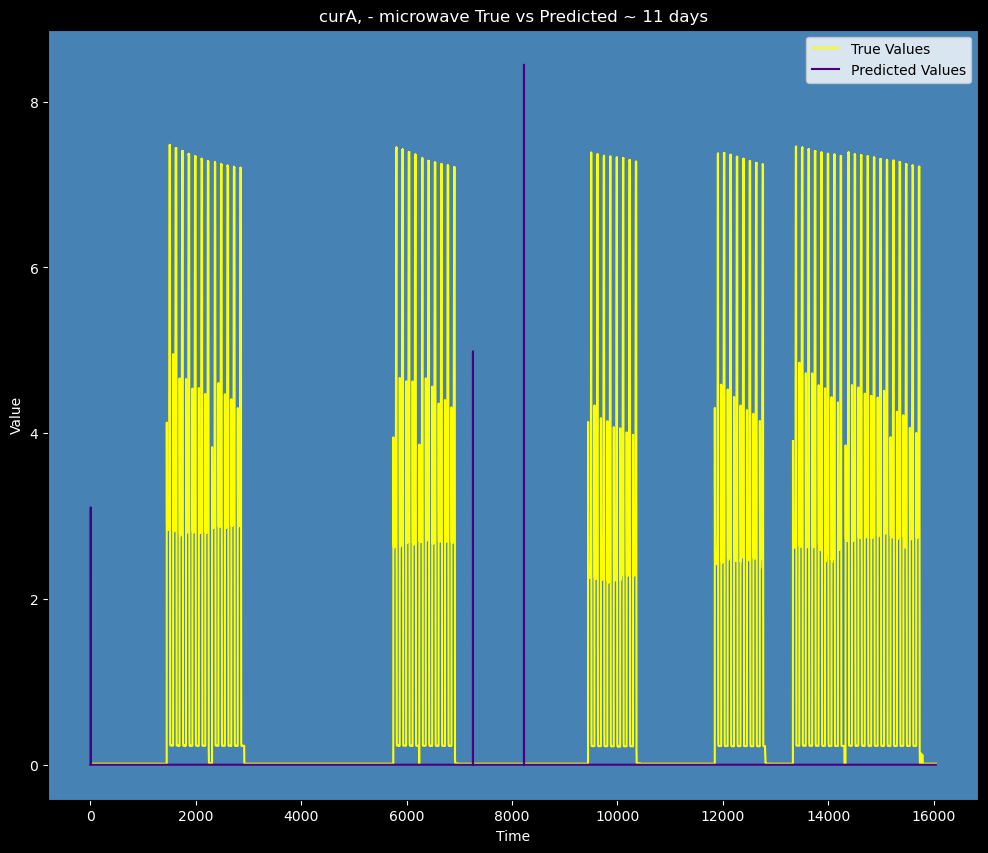

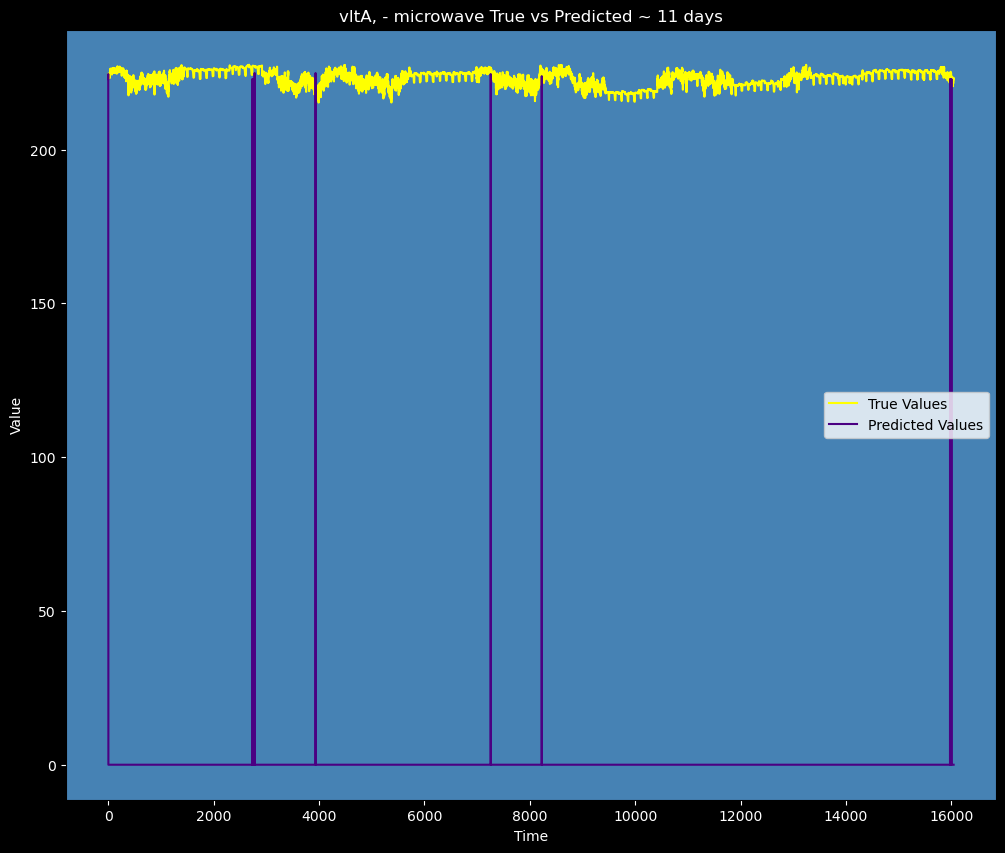

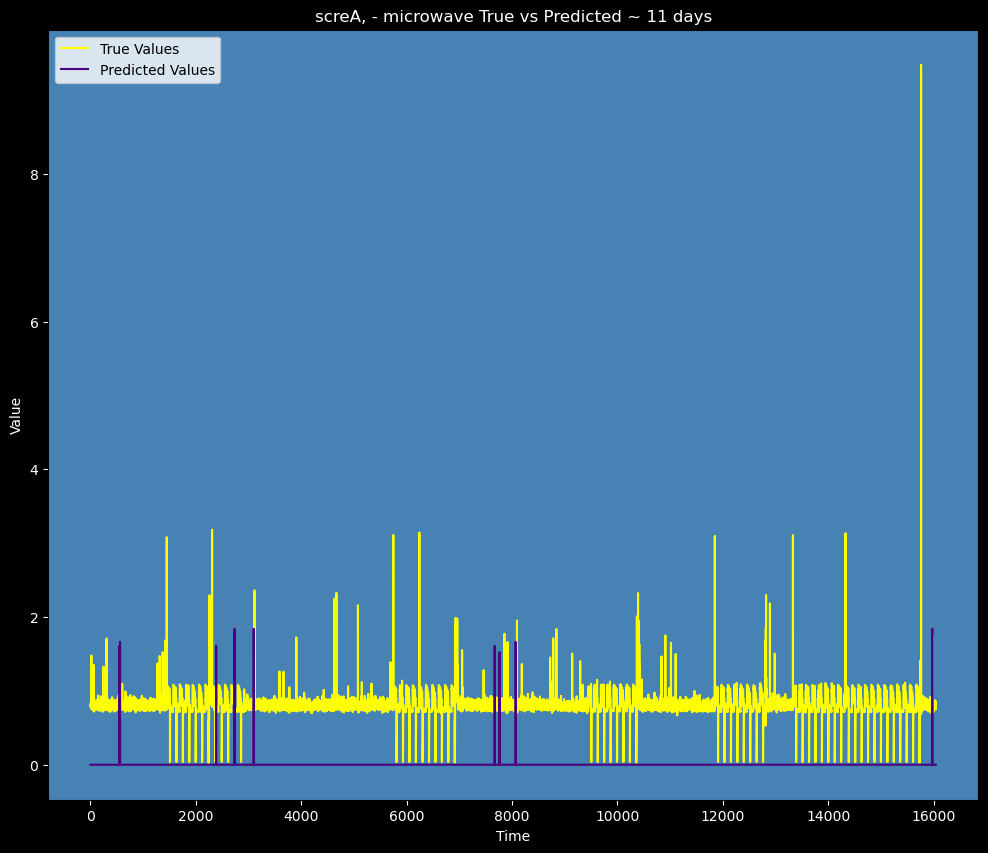

In [ ]:
import matplotlib.pyplot as plt
column_names = ['pwrA', 'apwrA','curA', 'vltA','screA']
j = 0
# Plotting the predicted values against the true values for each column
for i in range(Y_test_microwave.shape[1]):
    column_name = f"Column {i+1}"
    column_true = Y_test_microwave[:, i]
    column_pred = disaggregated_data_microwave[:, i]

    fig, ax = plt.subplots(figsize=(12, 10))
    fig.patch.set_facecolor('black')

    ax.plot(column_true, label="True Values", color='yellow')
    ax.plot(column_pred, label="Predicted Values", color = 'indigo')
    ax.set_xlabel("Time",color= 'white')
    ax.set_ylabel("Value", color = 'white')
    ax.set_title(column_names[j]+", - microwave True vs Predicted ~ 11 days", color = 'white')
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    ax.legend()

    # Change the color of the plot background
    ax.set_facecolor('steelblue')

    plt.show()
    j +=1

In [ ]:
## the predictions here are not good at all so we are not going to try to isolate day intervals

## Hotplate ##

X_train_hotplate, X_test_hotplate, Y_train_hotplate, Y_test_hotplate = aggregated_train.values, aggregated_test.values, hotplate_train.values, hotplate_test.values

hart85_disaggregator_hotplate = Hart85(num_states=5, num_cluster=5)
hart85_disaggregator_hotplate.train(X_train_hotplate)

disaggregated_data_hotplate = hart85_disaggregator_hotplate.disaggregate(X_test_hotplate)

columns = ["pwrA", "apwrA", "curA", "cltA", "screA"]

# Create an empty dictionary to store the metrics
metrics = {}

# Calculate and store the metrics for each column
for column in columns:
    column_true = Y_test_hotplate[:, columns.index(column)]
    column_pred = disaggregated_data_hotplate[:, columns.index(column)]

    rmse = hart85_disaggregator_hotplate.calculate_rmse(column_true, column_pred)
    mae = hart85_disaggregator_hotplate.calculate_mae(column_true, column_pred)
    rmae = hart85_disaggregator_hotplate.calculate_rmae(column_true, column_pred)
    mse = hart85_disaggregator_hotplate.calculate_mse(column_true, column_pred)
    r_squared = r2_score(column_true, column_pred)

    metrics[column] = {
        'RMSE': rmse,
        'MAE': mae,
        'RMAE': rmae,
        'MSE': mse,
        'R-squared': r_squared
    }

# Print the metrics for each column
for column, metrics_dict in metrics.items():
    print(f"Metrics for {column}:")
    for metric, value in metrics_dict.items():
        print(f"{metric}: {value}")
    print()


/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Metrics for pwrA:
RMSE: 201.03762594786153
MAE: 35.30756300863143
RMAE: 5.733737366976119
MSE: 40416.12704675229
R-squared: -0.03936971695283953

Metrics for apwrA:
RMSE: 203.6202233347212
MAE: 35.90649075751686
RMAE: 5.756769999239775
MSE: 41461.19535088174
R-squared: -0.052643923026095774

Metrics for curA:
RMSE: 0.915986476500708
MAE: 0.1611777674650697
RMAE: 5.726597724219401
MSE: 0.839031225132182
R-squared: -0.04066590225404054

Metrics for cltA:
RMSE: 222.57506842957534
MAE: 222.48975366390007
RMAE: 0.999696914932248
MSE: 49539.66108643014
R-squared: -11441.067460016297

Metrics for screA:
RMSE: 1.3928303363103403
MAE: 1.3840887378705518
RMAE: 1.0058515092010587
MSE: 1.9399763457463757
R-squared: -81.2797262805672



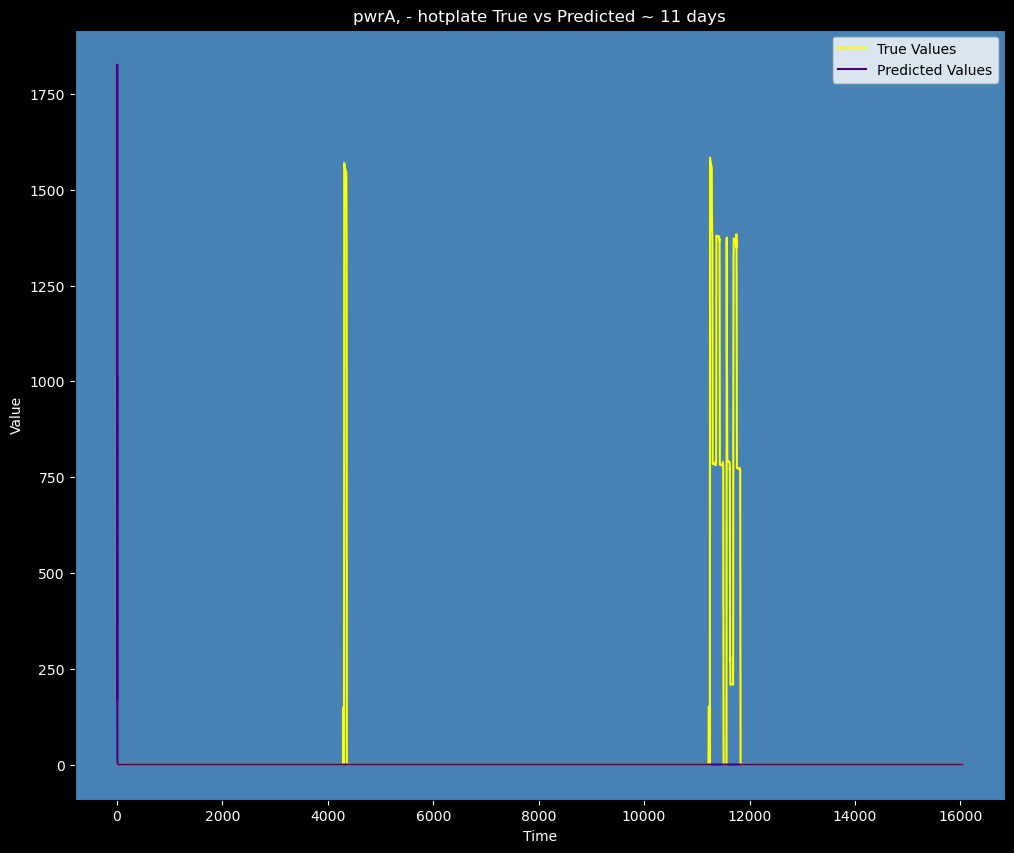

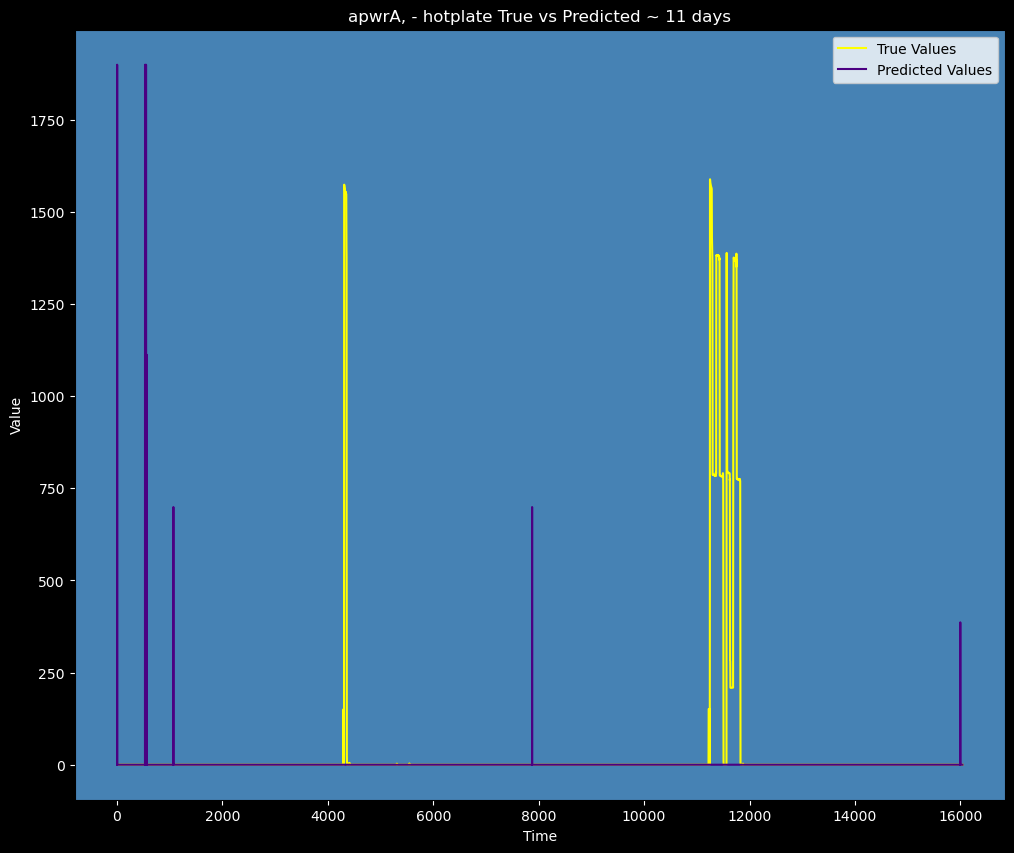

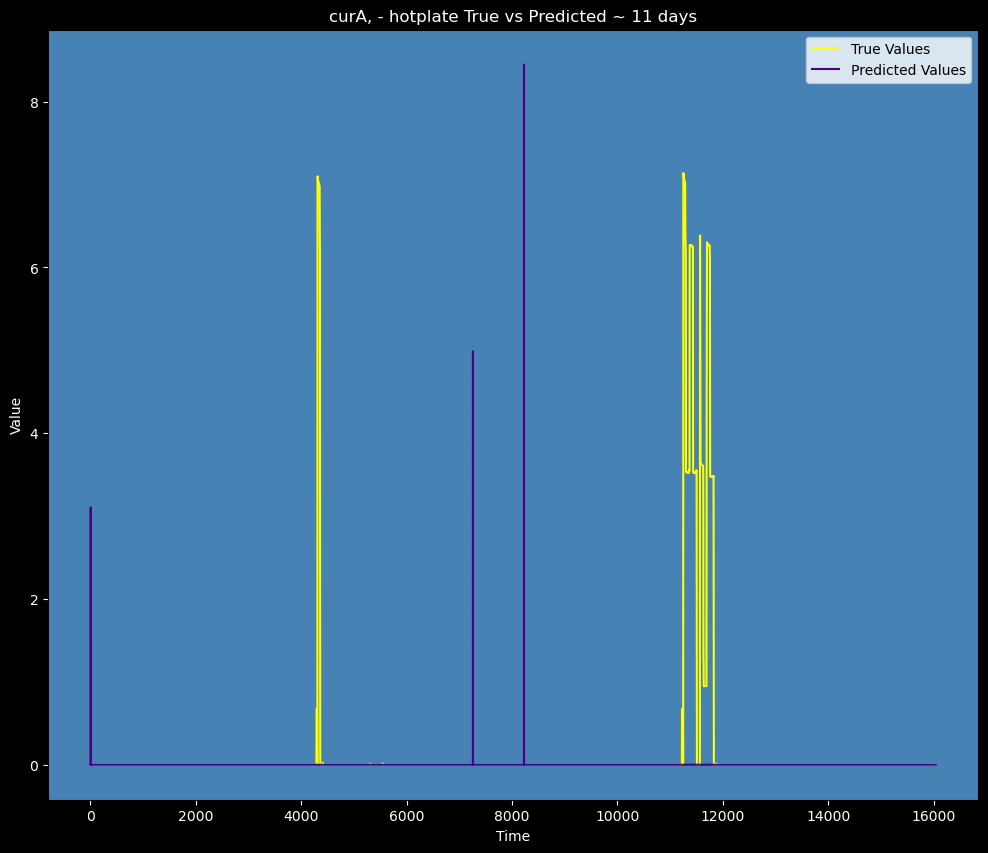

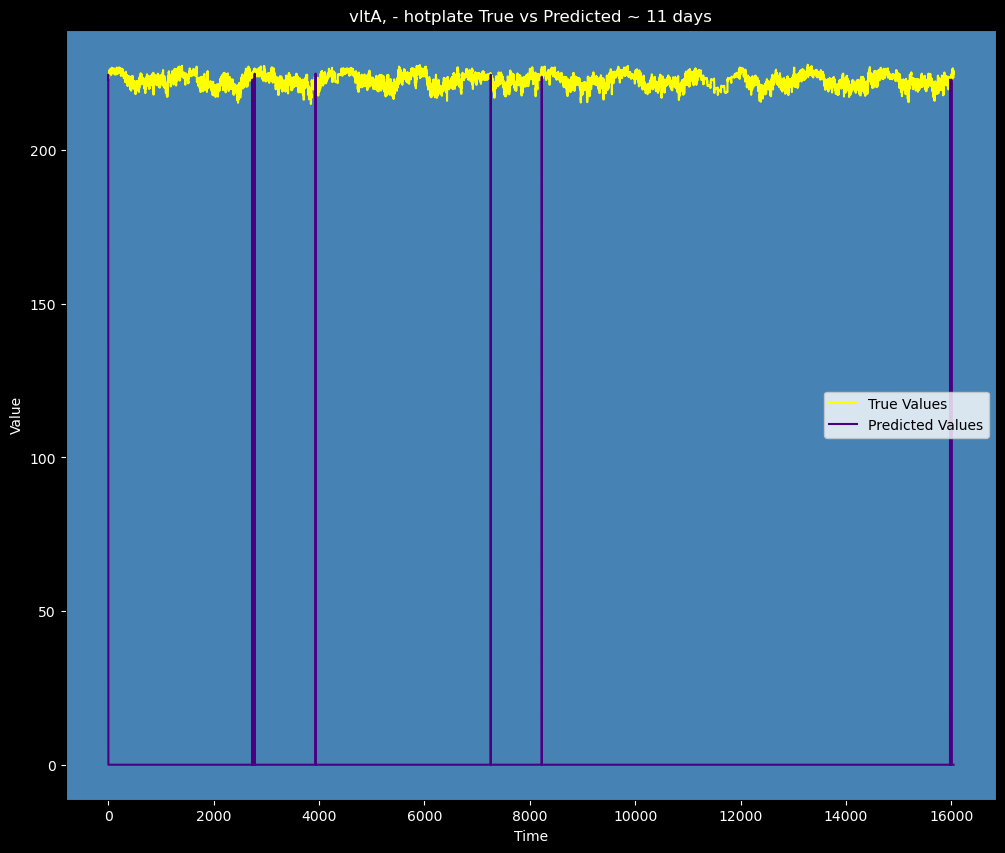

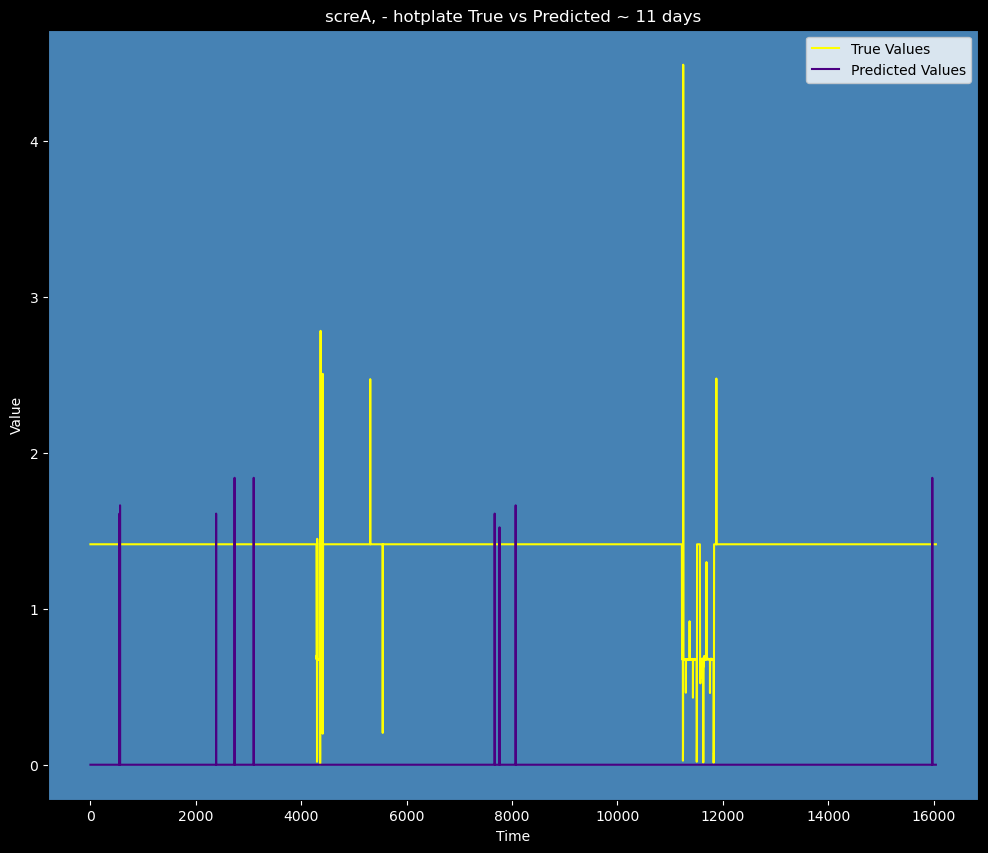

In [ ]:
import matplotlib.pyplot as plt
column_names = ['pwrA', 'apwrA','curA', 'vltA','screA']
j = 0
# Plotting the predicted values against the true values for each column
for i in range(Y_test_hotplate.shape[1]):
    column_name = f"Column {i+1}"
    column_true = Y_test_hotplate[:, i]
    column_pred = disaggregated_data_hotplate[:, i]

    fig, ax = plt.subplots(figsize=(12, 10))
    fig.patch.set_facecolor('black')

    ax.plot(column_true, label="True Values", color='yellow')
    ax.plot(column_pred, label="Predicted Values", color = 'indigo')
    ax.set_xlabel("Time",color= 'white')
    ax.set_ylabel("Value", color = 'white')
    ax.set_title(column_names[j]+", - hotplate True vs Predicted ~ 11 days", color = 'white')
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    ax.legend()

    # Change the color of the plot background
    ax.set_facecolor('steelblue')

    plt.show()
    j +=1

In [ ]:
## the predictions here are not good at all so we are not going to try to isolate day intervals

## water_heater ##

X_train_water_heater, X_test_water_heater, Y_train_water_heater, Y_test_water_heater = aggregated_train.values, aggregated_test.values, water_heater_train.values, water_heater_test.values

hart85_disaggregator_water_heater = Hart85(num_states=5, num_cluster=5)
hart85_disaggregator_water_heater.train(X_train_water_heater)

disaggregated_data_water_heater = hart85_disaggregator_water_heater.disaggregate(X_test_water_heater)

columns = ["pwrA", "apwrA", "curA", "cltA", "screA"]

# Create an empty dictionary to store the metrics
metrics = {}

# Calculate and store the metrics for each column
for column in columns:
    column_true = Y_test_water_heater[:, columns.index(column)]
    column_pred = disaggregated_data_water_heater[:, columns.index(column)]

    rmse = hart85_disaggregator_water_heater.calculate_rmse(column_true, column_pred)
    mae = hart85_disaggregator_water_heater.calculate_mae(column_true, column_pred)
    rmae = hart85_disaggregator_water_heater.calculate_rmae(column_true, column_pred)
    mse = hart85_disaggregator_water_heater.calculate_mse(column_true, column_pred)
    r_squared = r2_score(column_true, column_pred)

    metrics[column] = {
        'RMSE': rmse,
        'MAE': mae,
        'RMAE': rmae,
        'MSE': mse,
        'R-squared': r_squared
    }

# Print the metrics for each column
for column, metrics_dict in metrics.items():
    print(f"Metrics for {column}:")
    for metric, value in metrics_dict.items():
        print(f"{metric}: {value}")
    print()


/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Metrics for pwrA:
RMSE: 17.36918635479528
MAE: 0.4389414353046604
RMAE: -173.9619915375551
MSE: 301.6886346276065
R-squared: -6210.304711836431

Metrics for apwrA:
RMSE: 16.73938915459044
MAE: 8.587126396241413
RMAE: 2.010182741501382
MSE: 280.20714926882005
R-squared: -14440.67281036841

Metrics for curA:
RMSE: 0.0682899724346746
MAE: 0.03797906401669849
RMAE: 1.8351197012185747
MSE: 0.004663520335128617
R-squared: -12349.453656178799

Metrics for cltA:
RMSE: 224.2486838234638
MAE: 224.16515458193675
RMAE: 0.9996892190597346
MSE: 50287.47219655584
R-squared: -15179.954651625547

Metrics for screA:
RMSE: 2.424152210977371
MAE: 2.3745061877440854
RMAE: 1.020523436579027
MSE: 5.8765139419864765
R-squared: -23.901546514444554



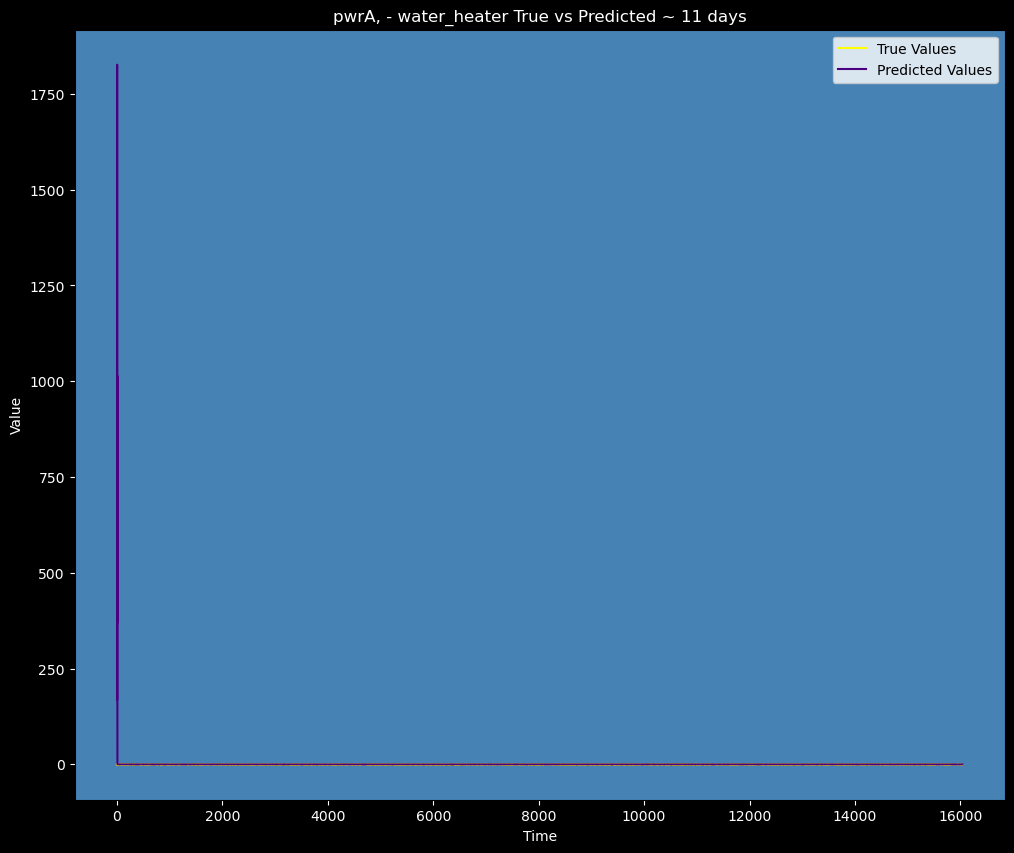

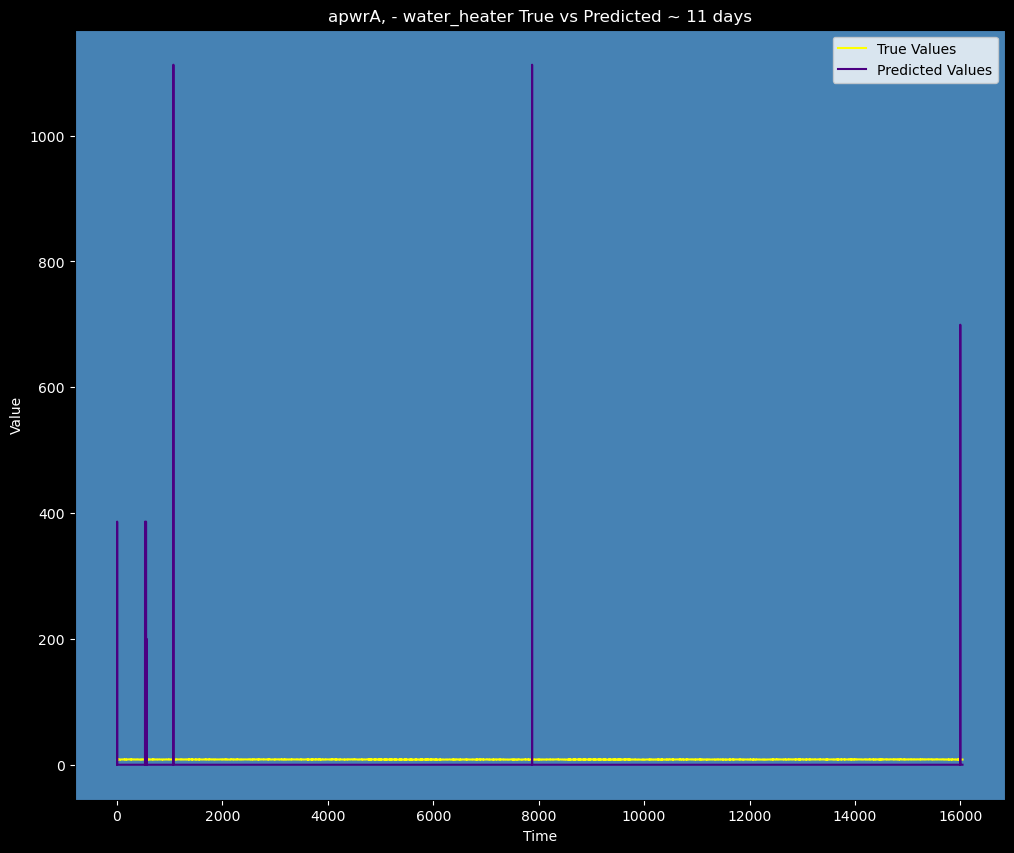

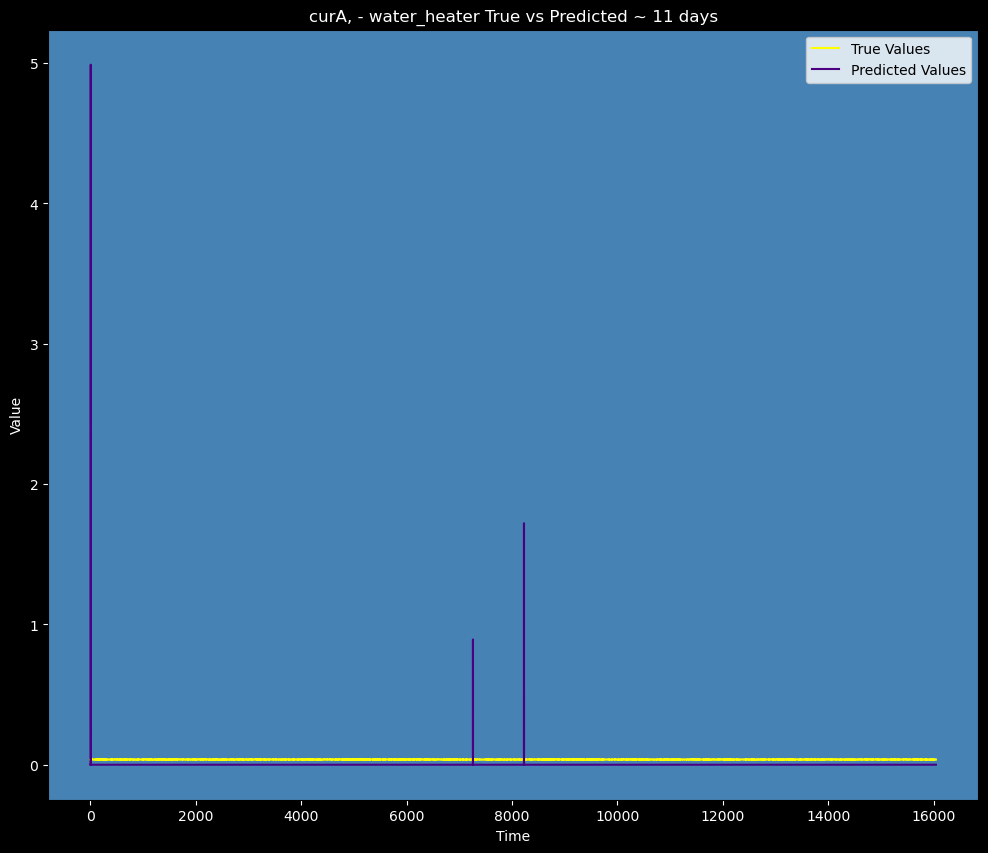

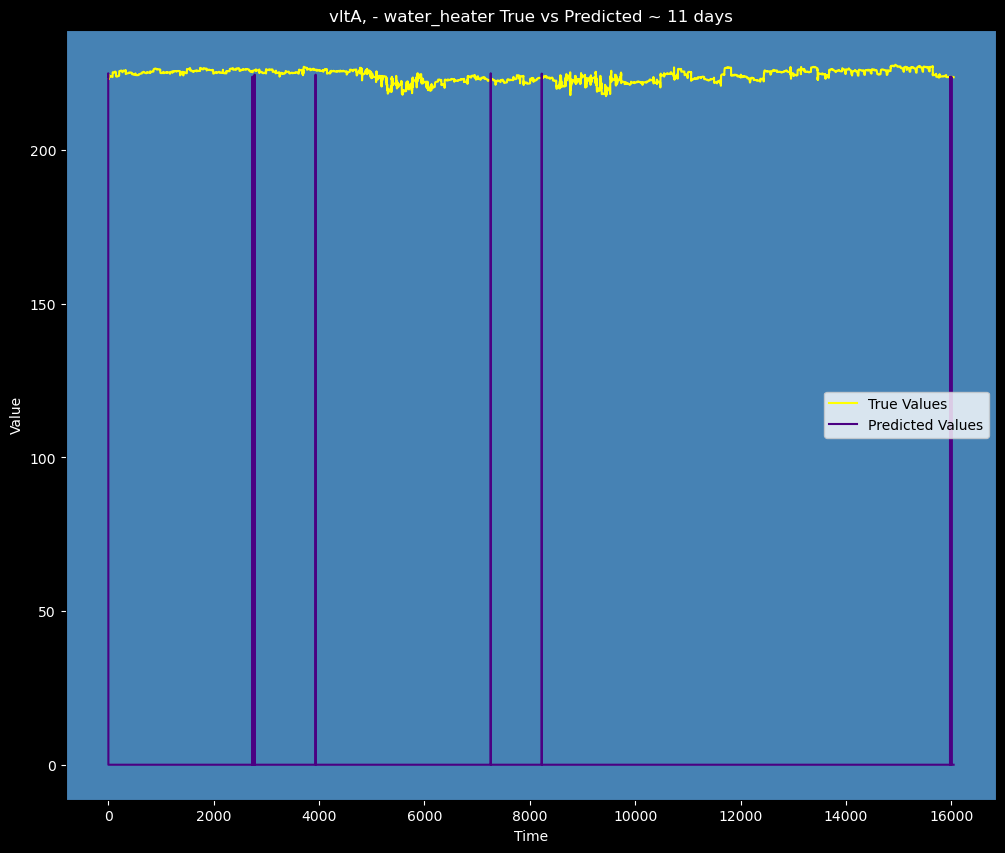

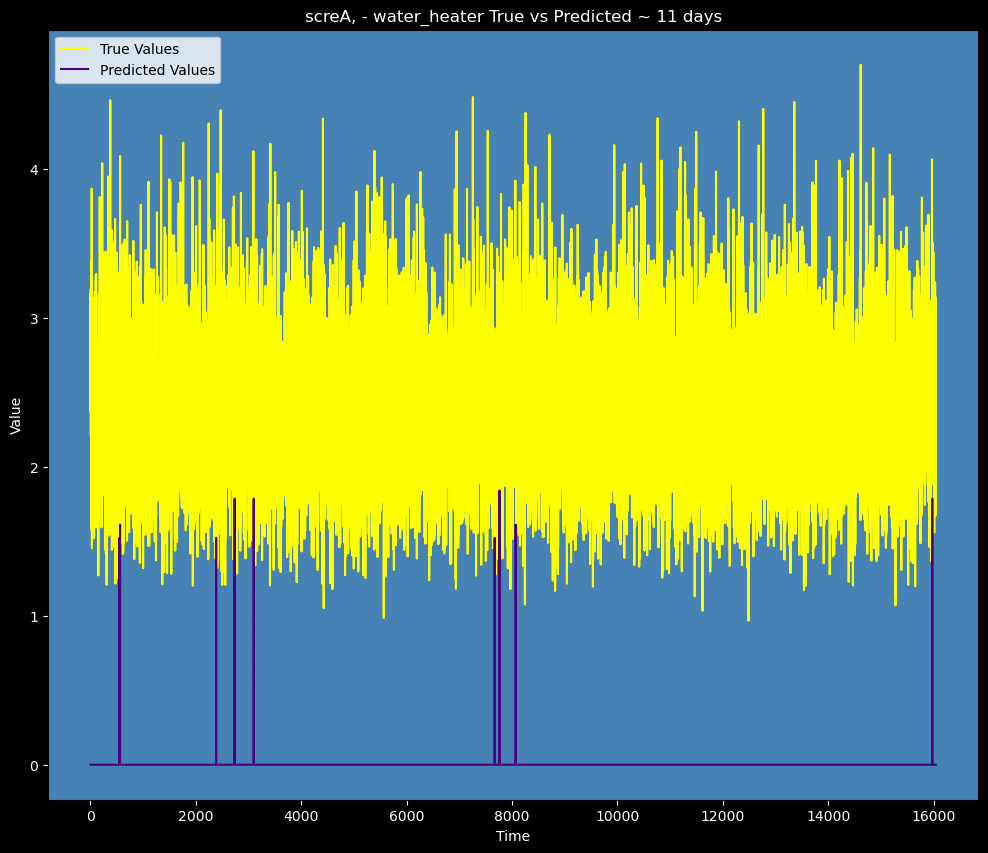

In [ ]:
import matplotlib.pyplot as plt
column_names = ['pwrA', 'apwrA','curA', 'vltA','screA']
j = 0
# Plotting the predicted values against the true values for each column
for i in range(Y_test_water_heater.shape[1]):
    column_name = f"Column {i+1}"
    column_true = Y_test_water_heater[:, i]
    column_pred = disaggregated_data_water_heater[:, i]

    fig, ax = plt.subplots(figsize=(12, 10))
    fig.patch.set_facecolor('black')

    ax.plot(column_true, label="True Values", color='yellow')
    ax.plot(column_pred, label="Predicted Values", color = 'indigo')
    ax.set_xlabel("Time",color= 'white')
    ax.set_ylabel("Value", color = 'white')
    ax.set_title(column_names[j]+", - water_heater True vs Predicted ~ 11 days", color = 'white')
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    ax.legend()

    # Change the color of the plot background
    ax.set_facecolor('steelblue')

    plt.show()
    j +=1